Authors:  

Valnose Adeline Edouazin - s134682  
Dimos Kadoglou - s205744  
Fotios Kotsalidis - s192909  
Katarzyna Otko - s202872  

# Imports


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from scipy import stats

# Data preparation

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/KasiaOtko/Cities_Challenge/main/Cities.csv')

In [ ]:
df.head()

Unnamed: 0           City  ...  Sprawl Factor  Network Density Factor
0         284  Baltimore(MD)  ...       0.722163                0.425187
1           9      Melbourne  ...       0.539355                0.558910
2         185         Niamey  ...       0.275605                0.410312
3         327          Hanoi  ...       0.666710                0.239113
4          66         Urumqi  ...       0.791822                0.075617

[5 rows x 79 columns]

In [ ]:
df.drop('Unnamed: 0', axis = 1, inplace = True)

Cleaning *City* column from parenthesis so it becomes more suitable for merging with supplementary datasets:

In [ ]:
df.City = df.City.str.split('(', expand = True)[0]
df.rename(columns={'Pollution Index ': 'Pollution Index'}, inplace = True)
df.head()

City  cityID  ...  Sprawl Factor Network Density Factor
0  Baltimore     285  ...       0.722163               0.425187
1  Melbourne      10  ...       0.539355               0.558910
2     Niamey     186  ...       0.275605               0.410312
3      Hanoi     328  ...       0.666710               0.239113
4     Urumqi      67  ...       0.791822               0.075617

[5 rows x 78 columns]

## Converting value types

We noticed that two columns, expected to be of a numeric data type, are, in fact, objects. Additionally, it is advisable to change nominal variables to a *category* data type. 
This is done below:

In [ ]:
# From string (object) to numeric
df['Bicycle Modeshare (%)'].replace(' ', np.nan, inplace = True)
df['Bicycle Modeshare (%)'] = pd.to_numeric(df['Bicycle Modeshare (%)'])
df['Bikeshare Stations'].replace(' ', np.nan, inplace = True)
df['Bikeshare Stations'] = pd.to_numeric(df['Bikeshare Stations'])

# From string (object) to category/nominal
df['clusterID'] = df['clusterID'].astype('category')
df['cityID'] = df['cityID'].astype('category')
df['Typology'] = df['Typology'].astype('category')
df['City'] = df['City'].astype('category')
df['Country'] = df['Country'].astype('category')

## Investigating missing values

The below chunk outputs all the names of columns with missing values along with their number.

In [ ]:
missing = df.isna().sum()
missing = missing[missing > 0].sort_values(ascending = False)
print('Number of columns with missing values: {} \n'.format(missing.shape[0]))
missing

Number of columns with missing values: 48 



Travel Time Index                                  189
Traffic Index                                      189
Inefficiency Index                                 189
Congestion (%)                                     166
Congestion PM Peak (%)                             166
Congestion AM Peak (%)                             166
Pollution Index                                    161
Bicycle Modeshare (%)                              147
Unemployment Rate (%)                              138
Poverty Rate (%)                                   137
Walking Modeshare (%)                              132
Safety Index                                       124
Smartphone Penetration (%)                         112
Local Purchasing Power Index                       108
Cost of Living Index                               108
Rent Index                                         108
Grocery Index                                      108
Restaurant Price Index                             108
Car Modesh

### Imputation with mean and median
We decided to replace missing values with mean or median (depending on the distribution) in features containing **less than 73 incomplete values**.  
In order to do this wisely, we investigate skewness of the data to decide which measure to choose.
Therefore, if a skewness of a data is between -1.5 and 1.5, we will use a mean to replace missing values. Otherwise we use a median.  
Dropping observations is not a good idea here because too many columns have too many missing values. In this case removing observations can lead to reduced number of degrees of freedom as the number of independent pieces of information goes down. This is a side effect.


In [ ]:
cols_to_be_imputed = missing[missing <= 73].index.tolist()
temp = df.loc[:, cols_to_be_imputed]

replace_with_mean = temp.columns[(temp.skew() < 1.5) & (temp.skew() > -1.5)]
replace_with_median = temp.columns[(temp.skew() >= 1.5) | (temp.skew() <= -1.5)]
print(len(replace_with_mean) + len(replace_with_median) == temp.shape[1])

temp[replace_with_mean] = temp[replace_with_mean].apply(lambda x: x.fillna(np.mean(x)))
temp[replace_with_median] = temp[replace_with_median].apply(lambda x: x.fillna(x.median()))

df.loc[:, cols_to_be_imputed] = temp

True


What to do with the remaining features?  
  
We decided to take care only of those features that are mostly correlated with our target (*CO2 Emissions per Capita (metric tonnes)*) and do not have more than 110 missing values (which is around 30% of the dataset). If there are more of them, then the most appropriate course of action would be to drop those columns and not use in any ML algorithm.

The way we are going to handle the remaining features is through **`KNNImputer`** class from `sklearn` module. We decided to turn to distance-based technique because using simple linear regression model would introduce too much bias.  


If a share of missing values in a total number of observations is so high (in our case around 30%), replacing them simply with a mean or a median would impact the distributions too much.  
Example of such an undesirable effect of imputing so many missing values with just a mean can be found below:

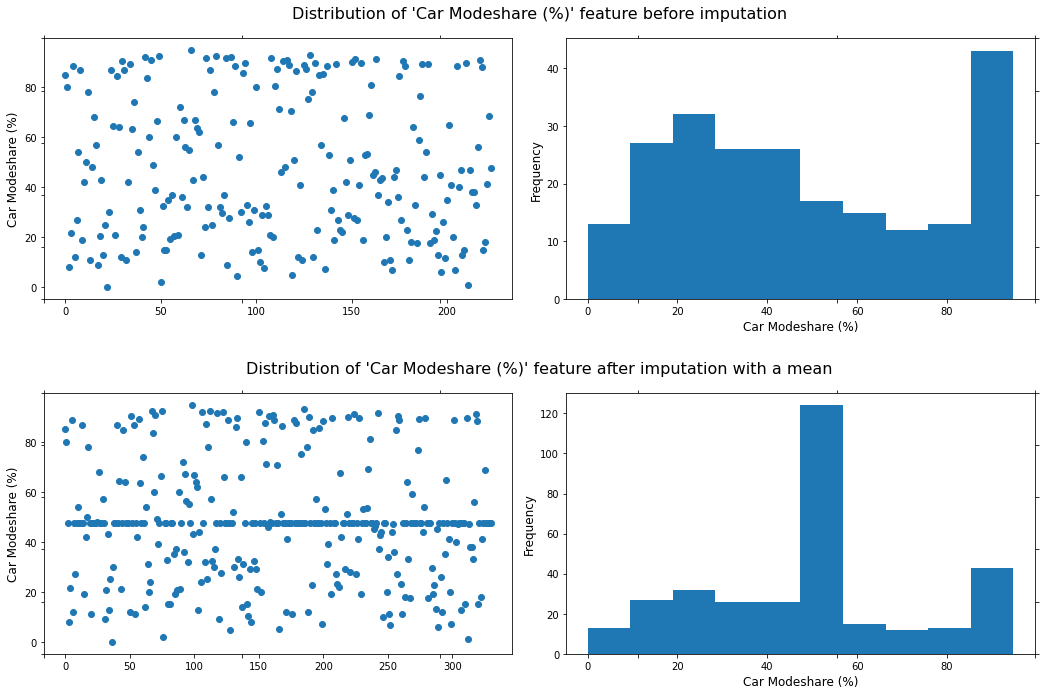

In [ ]:
feature = df['Car Modeshare (%)'].dropna()
feature_imputed = df['Car Modeshare (%)'].fillna(np.mean(df['Car Modeshare (%)']))

# Create two big subplots (each consisting of another two subplots) in order to insert a common title for each row
fig, big_axes = plt.subplots(figsize=(15, 10) , nrows=2, ncols=1, sharey=True)

big_axes[0].set_title("Distribution of 'Car Modeshare (%)' feature before imputation", fontsize=16, pad=20)
big_axes[0].tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
big_axes[0]._frameon = False
ax1 = fig.add_subplot(2,2,1)
ax1.scatter(range(len(feature)), feature)
ax1.set_ylabel('Car Modeshare (%)', fontsize = 12)
ax2 = fig.add_subplot(2,2,2)
ax2.hist(feature)
ax2.set_ylabel('Frequency', fontsize = 12)
ax2.set_xlabel('Car Modeshare (%)', fontsize = 12)

big_axes[1].set_title("Distribution of 'Car Modeshare (%)' feature after imputation with a mean", fontsize=16, pad=20)
big_axes[1].tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
big_axes[1]._frameon = False
ax3 = fig.add_subplot(2,2,3)
ax3.scatter(range(len(feature_imputed)), feature_imputed)
ax3.set_ylabel('Car Modeshare (%)', fontsize = 12)
ax4 = fig.add_subplot(2,2,4)
ax4.hist(feature_imputed)
ax4.set_ylabel('Frequency', fontsize = 12)
ax4.set_xlabel('Car Modeshare (%)', fontsize = 12)

fig.tight_layout()

### KNN Imputer

Here we can see what are the rest of columns with missing values. As mentioned earlier, we will drop those which miss over 112 values.

In [ ]:
missing = df.isna().sum()
missing = missing[missing > 0].sort_values()
print(missing)
cols_to_drop = missing[missing > 112].index.tolist()
df = df.drop(cols_to_drop, axis = 1)
print(df.shape)

Public Transit Modeshare (%)    104
Gini Coefficient                105
Car Modeshare (%)               107
Local Purchasing Power Index    108
Restaurant Price Index          108
Grocery Index                   108
Rent Index                      108
Cost of Living Index            108
Smartphone Penetration (%)      112
Safety Index                    124
Walking Modeshare (%)           132
Poverty Rate (%)                137
Unemployment Rate (%)           138
Bicycle Modeshare (%)           147
Pollution Index                 161
Congestion PM Peak (%)          166
Congestion AM Peak (%)          166
Congestion (%)                  166
Travel Time Index               189
Traffic Index                   189
Inefficiency Index              189
dtype: int64
(331, 66)


Let's find out which of the remaining columns (with a total number of missing values between 73 and 112) are correlated with the target variable.  
A below dataframe presents Pearson correlation coefficient along with its p-value, which indicates statistical significance of this coefficient.

In [ ]:
# update missing values counts
missing = df.isna().sum()
missing = missing[missing > 0].sort_values(ascending = False)

# create a temporary dataframe with the remaining columns and the target variable to compute correlations
temp = df[missing.index.tolist() + ['CO2 Emissions per Capita (metric tonnes)']]

# empty dataframe to store a ccorrelation oefficient and a p-value
corr_pvalue_df = pd.DataFrame(columns = ['Correlation', 'P-value'], index = temp.drop('CO2 Emissions per Capita (metric tonnes)', axis = 1).columns)

for i in range(temp.shape[1]-1):
  a = pd.DataFrame(data = {'X': temp.iloc[:, i], 'Y': temp.loc[:,'CO2 Emissions per Capita (metric tonnes)']})
  a.dropna(inplace = True)
  corr_pvalue_df.iloc[i, 0], corr_pvalue_df.iloc[i, 1] = stats.pearsonr(a.iloc[:,0], a.iloc[:,1])

corr_pvalue_df.sort_values(by = 'Correlation', ascending=False)

Correlation      P-value
Car Modeshare (%)               0.646258   7.0904e-28
Local Purchasing Power Index    0.642307  2.45118e-27
Smartphone Penetration (%)      0.623024  6.10838e-25
Grocery Index                   0.540298  2.66687e-18
Restaurant Price Index          0.523771  4.13391e-17
Cost of Living Index            0.506731  5.99358e-16
Rent Index                      0.412118  1.48766e-10
Gini Coefficient               0.0434933      0.51535
Public Transit Modeshare (%)   -0.485834  7.56227e-15

We can see that some of the remaining features are correlated with the target variable. Looking at the *P-value* column in the above dataframe, we can also notice that each of those high correlation coefficients is statistically significant (which is indicated by the p-value lower than 0.05).  
We decided to choose all the features whose **absolute value of correlation** with the target (*CO2 Emissions per Capita (metric tonnes)*) **is greater than 0.45**.

In [ ]:
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

KNN Imputer

In [ ]:
# Copying main dataset for the purpose of presenting the results later on
df_clean = df.copy()

# Defining a function that automates the process of imputing missing values for multiple features
def KNN_impute_missing_values(corr_treshold):

  # Select features whose absolute value of correlation with the target is greater than a corr_treshold
  cols_for_prediction = corr_pvalue_df[abs(corr_pvalue_df['Correlation']) > corr_treshold].index.tolist()
  print('Number of features selected for prediction of missing values: {0}\n'.format(len(cols_for_prediction)))
  print(cols_for_prediction)

  for i in range(len(cols_for_prediction)): # for every column that was chosen for imputation of missing values...
    print('Predicting missing values for:', cols_for_prediction[i])

    # Select columns that were not chosen for imputation
    cols_to_drop = missing[missing.index != cols_for_prediction[i]].index.tolist()

    # Drop those columns along with categorical variables from a main dataframe so that they are not taken under consideration while calculating correlation with the remaing features
    corr = df.drop(cols_to_drop + ['City', 'cityID', 'clusterID', 'Typology', 'Country'], axis = 1).corr()[cols_for_prediction[i]]

    # Select relevant features for the KNN imputer
    corr = corr[(abs(corr) > 0.45)]
    cols = corr.index.tolist()

    # Create a temporary dataframe
    data = df[cols]
    # Standardization
    data_std = (data-np.mean(data))/np.std(data)

    # Modelling
    imputer = KNNImputer(n_neighbors=5)
    imputer.fit(data_std)
    data_imputed = pd.DataFrame(imputer.transform(data_std), columns = data_std.columns)
    print('\n')

    # Replace missing values with the imputed ones in a new (copied) dataframe
    df_clean.loc[:,cols_for_prediction[i]] = data_imputed[cols_for_prediction[i]]

In [ ]:
KNN_impute_missing_values(corr_treshold = 0.45)

Number of features selected for prediction of missing values: 7

['Smartphone Penetration (%)', 'Local Purchasing Power Index', 'Restaurant Price Index', 'Grocery Index', 'Cost of Living Index', 'Car Modeshare (%)', 'Public Transit Modeshare (%)']
Predicting missing values for: Smartphone Penetration (%)


Predicting missing values for: Local Purchasing Power Index


Predicting missing values for: Restaurant Price Index


Predicting missing values for: Grocery Index


Predicting missing values for: Cost of Living Index


Predicting missing values for: Car Modeshare (%)


Predicting missing values for: Public Transit Modeshare (%)




What is the result?

In [ ]:
print('Before cleaning:\n',df.isna().sum().value_counts())
print('\nAfter cleaning:\n',df_clean.isna().sum().value_counts())

Before cleaning:
 0      57
108     5
112     1
107     1
105     1
104     1
dtype: int64

After cleaning:
 0      64
108     1
105     1
dtype: int64


In [ ]:
missing = df_clean.isna().sum()
missing = missing[missing > 0]
print(missing)
df_clean = df_clean.drop(missing.index.tolist(), axis = 1)

Rent Index          108
Gini Coefficient    105
dtype: int64


We can see that the number of columns with no missing values increased by 7, which is the number of columns that was selected for the KNN imputation. The last two columns that we need to drop are *Rent Index* and *Gini Coefficient* as they do not sufficiently correlate with the target to try impute so many incomplete values they contain.   
A chart below compares the effect of using two approaches for imputation of missing values on the example of *Car Modeshare (%)* feature.

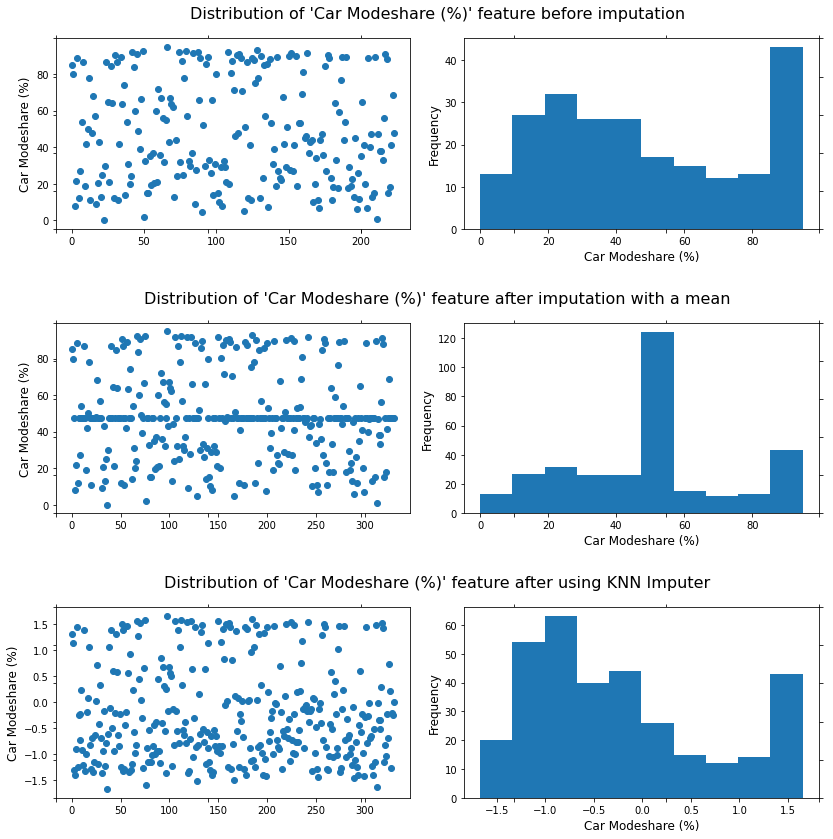

In [ ]:
feature = df['Car Modeshare (%)'].dropna()
feature_imputed = df['Car Modeshare (%)'].fillna(np.mean(df['Car Modeshare (%)']))
feature_predicted = df_clean['Car Modeshare (%)']

# Create three big subplots (each consisting of another two subplots) in order to insert a common title for each row
fig, big_axes = plt.subplots(figsize=(12, 12) , nrows=3, ncols=1, sharey=True)

big_axes[0].set_title("Distribution of 'Car Modeshare (%)' feature before imputation", fontsize=16, pad=20)
big_axes[0].tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
big_axes[0]._frameon = False
ax1 = fig.add_subplot(3,2,1)
ax1.scatter(range(len(feature)), feature)
ax1.set_ylabel('Car Modeshare (%)', fontsize = 12)
ax2 = fig.add_subplot(3,2,2)
ax2.hist(feature)
ax2.set_ylabel('Frequency', fontsize = 12)
ax2.set_xlabel('Car Modeshare (%)', fontsize = 12)

big_axes[1].set_title("Distribution of 'Car Modeshare (%)' feature after imputation with a mean", fontsize=16, pad=20)
big_axes[1].tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
big_axes[1]._frameon = False
ax3 = fig.add_subplot(3,2,3)
ax3.scatter(range(len(feature_imputed)), feature_imputed)
ax3.set_ylabel('Car Modeshare (%)', fontsize = 12)
ax4 = fig.add_subplot(3,2,4)
ax4.hist(feature_imputed)
ax4.set_ylabel('Frequency', fontsize = 12)
ax4.set_xlabel('Car Modeshare (%)', fontsize = 12)

big_axes[2].set_title("Distribution of 'Car Modeshare (%)' feature after using KNN Imputer", fontsize=16, pad=20)
big_axes[2].tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
big_axes[2]._frameon = False
ax3 = fig.add_subplot(3,2,5)
ax3.scatter(range(len(feature_predicted)), feature_predicted)
ax3.set_ylabel('Car Modeshare (%)', fontsize = 12)
ax4 = fig.add_subplot(3,2,6)
ax4.hist(feature_predicted)
ax4.set_ylabel('Frequency', fontsize = 12)
ax4.set_xlabel('Car Modeshare (%)', fontsize = 12)
fig.tight_layout()

Additionally, let's check how, on average, a correlation with the target variable (*CO2 Emissions per Capita (metric tonnes)*) has changed after replacing missing values with the imputed by the KNN ones. We would like it to be as low as possible, since a low change would mean that the general structure or distribution of a variable was not violated. Below compared is the result after KNN imputation with the result of a simple replacement with a mean.


In [ ]:
cols_for_KNN = corr_pvalue_df[abs(corr_pvalue_df['Correlation']) > 0.45].index.tolist()    # selecting 12 names of columns that were chosen for prediction
corr_before = df[cols_for_KNN + ['CO2 Emissions per Capita (metric tonnes)']].corr()['CO2 Emissions per Capita (metric tonnes)']
corr_after_KNN = df_clean[cols_for_KNN + ['CO2 Emissions per Capita (metric tonnes)']].corr()['CO2 Emissions per Capita (metric tonnes)']

comparison = abs(corr_before - corr_after_KNN)[:-1]
print('Average change in correlation after using KNN Imputer:', round(comparison.mean(), 4))

corr_after_imputation = df[cols_for_KNN + ['CO2 Emissions per Capita (metric tonnes)']]\
                        .apply(lambda x:x.fillna(np.mean(x)))\
                        .corr()['CO2 Emissions per Capita (metric tonnes)']

comparison = abs(corr_before - corr_after_imputation)[:-1]
print('Average change in correlation after imputing missing values with a mean:', round(comparison.mean(), 4))

Average change in correlation after using KNN Imputer: 0.0303
Average change in correlation after imputing missing values with a mean: 0.0898


To sum up, both the charts and the comparison of change in correlation indicate that using KNN imputer to replace missing values is in this case a much better solution.  
We then replace our main dataframe (*df*) with it's clean version (*df_clean*).

In [ ]:
df = df_clean

In [ ]:
missing = df.isna().sum()
missing[missing > 0]

Series([], dtype: int64)

# Importing additional dataset

The source of the supporting dataset: https://www.numbeo.com/quality-of-life/rankings.jsp  
From this data we will mainly use variables like *Quality of Life Index* as well as *Safety Index* and *Health Care Index*. The rest of them are quite similar to the ones that are already in a *Cities* dataset.

In [ ]:
lifeQuality = pd.read_csv('https://raw.githubusercontent.com/KasiaOtko/Cities_Challenge/main/LifeQuality.csv')
lifeQuality.City = lifeQuality.City.str.split(',', expand = True)[0]
lifeQuality.City = lifeQuality.City.str.split('(', expand = True)[0].str.strip()

# in this dataset there two San Jose cities (one in Costa Rica and one in USA), we drop the one which is not present in Cities dataset (the one in USA)
lifeQuality.drop(197, inplace = True)

# drop the columns that are already in the Cities dataset
lifeQuality.drop(['Cost of Living Index', 'Pollution Index'], axis = 1, inplace = True)
print('Shape of a new dataset: ', lifeQuality.shape)
lifeQuality['City'] = lifeQuality['City'].astype('category')

# Data types are correct
print(lifeQuality.dtypes)
lifeQuality.head()

Shape of a new dataset:  (244, 9)
Rank                                 int64
City                              category
Quality of Life Index              float64
Purchasing Power Index             float64
Safety Index                       float64
Health Care Index                  float64
Property Price to Income Ratio     float64
Traffic Commute Time Index         float64
Climate Index                      float64
dtype: object


Rank         City  ...  Traffic Commute Time Index  Climate Index
0     1    Abu Dhabi  ...                       26.51          43.89
1     2     Adelaide  ...                       23.61          94.96
2     3    Ahmedabad  ...                       36.77          49.27
3     4  Albuquerque  ...                       25.56          67.06
4     5       Almaty  ...                       36.34          58.30

[5 rows x 9 columns]

We merge those two datasets by an inner join. A resulting dataset consists of 161 observations and 74 features.

In [ ]:
full_df = df.merge(lifeQuality, how = 'inner', on = 'City')
full_df.shape

(161, 72)

# Exploratory analysis


In the Data Preparation section we removed some of the features since they will not be suitable for prediction because of the number of missing values they contain. However, it does not mean that they are not useful for some visual analysis that we would like to present in this part of the report. Therefore, we read the full *Cities* data once again to make use of the information stored in a features like *Walking Modeshare (%)* or *Bicycle Modeshare (%)*. We create a separate dataframe with a 'for_analysis' suffix so that it does not interfere with the clean (*full_df*) dataframe already created.

In [ ]:
df_for_analysis = pd.read_csv('https://raw.githubusercontent.com/KasiaOtko/Cities_Challenge/main/Cities.csv')
df_for_analysis.drop('Unnamed: 0', axis = 1, inplace = True)
df_for_analysis.City = df_for_analysis.City.str.split('(', expand = True)[0]
df_for_analysis.rename(columns={'Pollution Index ': 'Pollution Index'}, inplace = True)
df_for_analysis['Bicycle Modeshare (%)'].replace(' ', np.nan, inplace = True)
df_for_analysis['Bicycle Modeshare (%)'] = pd.to_numeric(df_for_analysis['Bicycle Modeshare (%)'])
full_df_for_analysis = df_for_analysis.merge(lifeQuality, how = 'inner', on = 'City')
full_df_for_analysis.shape

(161, 86)

We noticed that the dataset cotains many features that are expressed as a percentage. We thought it would be interesting to look into their descriptive statistics since they would be clear to interpret.

In [ ]:
full_df_for_analysis.filter(like = '%').describe()

Car Modeshare (%)  ...  Smartphone Penetration (%)
count         134.000000  ...                  113.000000
mean           50.526772  ...                   54.292035
std            27.212231  ...                   19.403461
min             1.000000  ...                   11.000000
25%            27.150000  ...                   41.000000
50%            47.000000  ...                   60.000000
75%            78.000000  ...                   72.000000
max            94.800000  ...                   77.000000

[8 rows x 11 columns]

We can learn multiple insights from this:
* There are cities (or regions) which are fully urbanized (max(*Urbanization Rate 2015 (%))* = 100%);
* There are cities in which unemployment nearly does not exist (min(*Unemployment Rate (%)*) = 0.2%);
* In some areas citizens completely do not use cars or bikes as a type of transportation. Additionally, on the one hand, in some cities public transport does not exist, while on the other, there are cities where citizens nearly do not commute afoot;



## What is the relationship between modes of transportation and a quality of life?
We tried to find the correlation between the Quality of Life and how it affects the way people commute on their every days lives. 



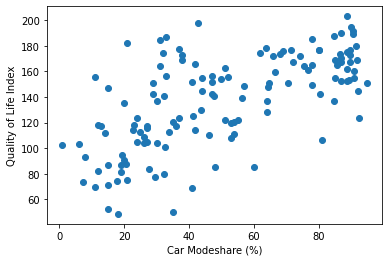

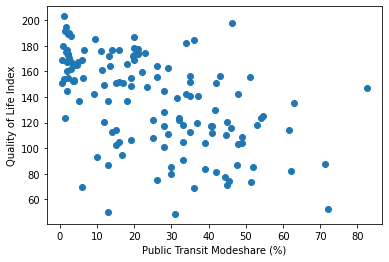

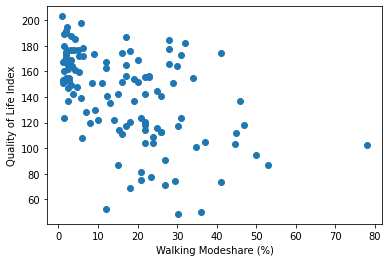

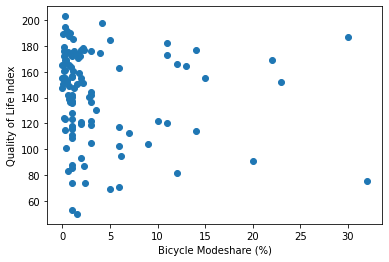

In [ ]:
columns_x = ['Car Modeshare (%)', 'Public Transit Modeshare (%)', 'Walking Modeshare (%)', 'Bicycle Modeshare (%)']
target_cor = 'Quality of Life Index'

for columns_x2 in columns_x:
    plt.scatter(full_df_for_analysis[columns_x2], full_df_for_analysis[target_cor])
    plt.xlabel(columns_x2)
    plt.ylabel(target_cor)
    plt.show()

From these observations, we can conclude that:

1. It is pretty clear that as the quality of life increases so does the use of car modeshare, and the coorelation between those seems to be linear.
2. As the quality of life increases, the use of Public Transit Modeshare decreases. The correlation between the values again appear to be linear, but with a negative slope.
3. It can be seen that no matter the quality of life, people of all social statuses do not walk much. That being said, there is a cluster of values on the top left of the scatter plot indicating that the higher the quality of life the fewer people walk. We can also comment on the fact that even though people with lower quality of life don't walk a lot, it is mostly due to the higher public Transportation network usage.
4. The usage of bicycles is pretty much the same as walking, but it emphasizes our observations even more.



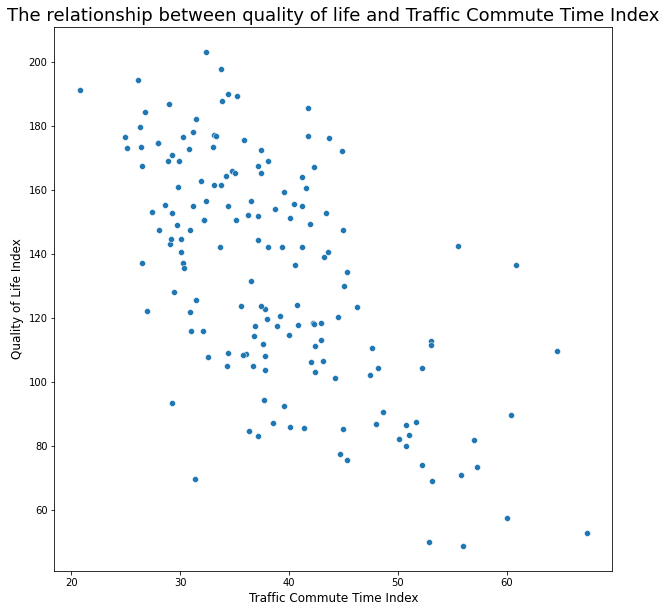

In [ ]:
plt.figure(figsize = (10, 10))
b = sns.scatterplot(data = full_df, x = 'Traffic Commute Time Index', y = 'Quality of Life Index');
b.set_xlabel('Traffic Commute Time Index', fontsize = 12)
b.set_ylabel('Quality of Life Index', fontsize = 12)
b.set_title('The relationship between quality of life and Traffic Commute Time Index', fontsize = 18);

Furthermore, we can see a linear correlation with a negative slope between the quality of life and the commute time. This basically backs the results that people of lower quality class use the public transportation means more, leading to a significantly more time spent commuting than those of higher quality index who tend to use their car. 

## What correlates with longevity?

From now on we will use the clean dataframe (*full_df* instead of *full_df_for_analysis*), created in a Data Preparation section, that does not contain any missing values.

For the purpose of this part, first, we would like to create a binary variable out of a continuous one. Thus, we searched for a feature with a **bimodal distribution** so that the treshold that we would use to assign ones and zeros could result in a most meaningful division.
We found out that a feature *Development Factor* has the most evident bimodal distribution, as illustrated below.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


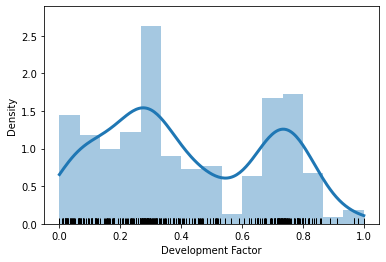

In [ ]:
sns.distplot(df['Development Factor'], hist = True, kde = True, rug = True,
             bins=15,
             kde_kws={'linewidth': 3, 'clip': (0.0, 1.0)},
             rug_kws={'color': 'black'});

Based on this, we add additional column that would indicate if a city is highly developed or not. We can see that the newly created categories are balanced.

In [ ]:
full_df['Developed?'] = full_df['Development Factor'].apply(lambda x: 'Yes' if x > 0.5 else 'No')
print('Value counts:\n', full_df['Developed?'].value_counts())
full_df.filter(like = 'Develop').head()

Value counts:
 Yes    83
No     78
Name: Developed?, dtype: int64


Development Factor Developed?
0            0.796264        Yes
1            0.786174        Yes
2            0.157676         No
3            0.730054        Yes
4            0.717663        Yes

Now we can visually investigate relationships between particular features using two-dimensional plots and add another dimension in a form of **color** - this would yield additional information for us and at the same time the plot stays in a two-dimensional space which is much easier to read and interpret for a human.

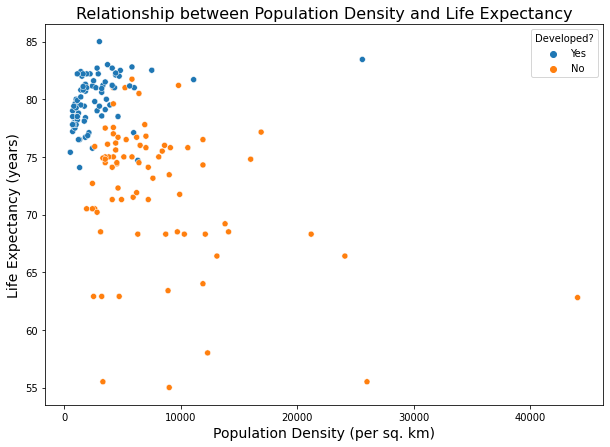

In [ ]:
plt.figure(figsize = (10, 7))
b = sns.scatterplot(data = full_df, x = 'Population Density (per sq. km)', y = 'Life Expectancy (years)', hue = 'Developed?');
b.set_xlabel('Population Density (per sq. km)', fontsize = 14)
b.set_ylabel('Life Expectancy (years)', fontsize = 14)
b.set_title('Relationship between Population Density and Life Expectancy', fontsize = 16);

We can also add a fourth dimension - **size**! For this purpose we used *Population Change 2010 – 2020* feature.

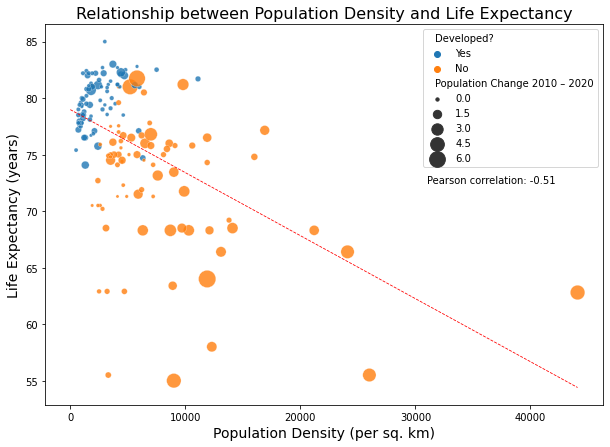

In [ ]:
# dropping Hong Kong as an outlier
full_df_HK_dropped = full_df.drop(137)

plt.figure(figsize = (10, 7))
b = sns.scatterplot(data = full_df_HK_dropped, x = 'Population Density (per sq. km)', y = 'Life Expectancy (years)', 
                hue = 'Developed?', 
                alpha = 0.8,
                size = 'Population Change 2010 – 2020',
                sizes = (10, 300));
b.set_xlabel('Population Density (per sq. km)', fontsize = 14)
b.set_ylabel('Life Expectancy (years)', fontsize = 14)
b.axes.set_title('Relationship between Population Density and Life Expectancy', fontsize = 16);

# Correlation annotation
cor = np.corrcoef(full_df_HK_dropped['Population Density (per sq. km)'], full_df_HK_dropped['Life Expectancy (years)'])[0][1]
b.text(31000, 72.5, "Pearson correlation: " + str(round(cor, 2)), horizontalalignment='left')

# fitting a trend line
z = np.polyfit(full_df_HK_dropped['Population Density (per sq. km)'], full_df_HK_dropped['Life Expectancy (years)'], 1)
p = np.poly1d(z)
xp = np.linspace(0, 44100, 1000)
plt.plot(xp,p(xp), 'r--', linewidth = 0.8);

From this we can clearly see that the lower the density of population, the longer duration of life we can expect. One explanation for this could be a fact that in overpopulated areas people have a limited access to all the necessary resources. Furthermore, cities with high population density are often the emerging ones, meaning that they are still developing and thus have not reached the highest longevity.  
Additionally, from the plot we can see that cities with a significantly high population change in recent years exist mainly among less developed ones which supports the view presented in a previous sentence.


## Clustering - what are the patterns whith regards to a standard of living?

Clustering is an example of an unsupervised machine learning method, as we do not use any dependent variable *$y$*. It aims to group observations in clusters. This is done by maximizing the distances between clusters and minimizing the distances between each of the observations within a cluster so that they have similar variance. By using the **within-cluster sum of squares** as a cost function, data points in the same cluster will be similar to each other, whereas data points in different clusters will have a lower level of similarity.    
**We apply clustering algorithms to our data in order to find clusters of cities with similar characteristics that influence the standard of living in a given city**.

### Feature selection

For the purposes of clustering we initially chose 8 variables (presented below) that in our opinion can give a sufficient image of the **standard of living** in a given city. We did not want the number of features to be too large as it could make the interpretation too sophisticated.

In [ ]:
cols = ['Congestion Factor', 'Internet Penetration', 'Purchasing Power Index',
        'GDP per Capita (USD)', 'Health Care Index', 'Cost of Living Index', 'Life Expectancy (years)', 'Safety Index', 'City', 'Country']
clust_df = full_df[cols]
clust_df.set_index(['Country', 'City'], inplace=True, drop = True)
clust_df.head()

Congestion Factor  ...  Safety Index
Country       City                          ...              
United States Baltimore           0.180085  ...         25.25
Australia     Melbourne           0.333173  ...         55.53
Vietnam       Hanoi               0.624623  ...         61.80
United States Milwaukee           0.098736  ...         32.81
France        Paris               0.587699  ...         48.14

[5 rows x 8 columns]

Now we need to identify all possible issues:
1. **Missing values**.  
  There are no missing values in the chosen features.



In [ ]:
print(clust_df.isna().sum())

Congestion Factor          0
Internet Penetration       0
Purchasing Power Index     0
GDP per Capita (USD)       0
Health Care Index          0
Cost of Living Index       0
Life Expectancy (years)    0
Safety Index               0
dtype: int64


2. **Variation coefficient**.  
  We decide to drop *Life Expectancy (years)* since the value of variation coefficient is below 0.1 which means that this feature's variability is too low to be considered for clustering.

In [ ]:
var_coeff = np.std(clust_df)/np.mean(clust_df)
print(var_coeff.sort_values())
clust_df.drop('Life Expectancy (years)', axis = 1, inplace = True)

Life Expectancy (years)       0.075922
Health Care Index             0.145614
Safety Index                  0.282747
Internet Penetration          0.294194
Congestion Factor             0.423377
Purchasing Power Index        0.473962
GDP per Capita (USD)          0.670290
Cost of Living Index       1526.479094
dtype: float64


3. **Colinearity**.  
  There is no need to drop additional columns as the correlation between all the features does not exceed 0.9.

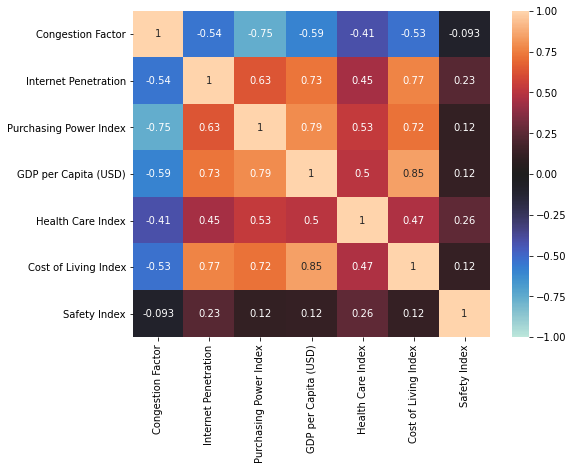

In [ ]:
plt.figure(figsize = (8, 6))
sns.heatmap(clust_df.corr(), vmin = -1, center = 0, vmax = 1, annot=True)

4. **Outliers**.  
  It is important to standardise the data and remove outliers since clustering algoritms are very sensitive to them. Based on a *three-sigma rule of thumb* (or *68–95–99.7 rule*) we identified that the feature *Cost of Living Index* contains one outlier - Zurich. It is removed. After restandardising the data, no more outliers were detected.

In [ ]:
clust_df_norm = (clust_df - np.mean(clust_df))/np.std(clust_df)
clust_df_norm.describe()

Congestion Factor  ...  Safety Index
count       1.610000e+02  ...  1.610000e+02
mean        1.301926e-15  ... -2.813484e-16
std         1.003120e+00  ...  1.003120e+00
min        -2.361961e+00  ... -2.368458e+00
25%        -6.516283e-01  ... -6.589520e-01
50%         1.916460e-01  ...  4.355804e-02
75%         7.238843e-01  ...  7.318760e-01
max         2.918204e+00  ...  2.435576e+00

[8 rows x 7 columns]

In [ ]:
print(clust_df_norm[clust_df_norm['Cost of Living Index'] > 3].index)
clust_df.drop(('Switzerland', 'Zurich'), inplace = True)

MultiIndex([('Switzerland', 'Zurich')],
           names=['Country', 'City'])


Our resulting clustering dataset has 160 observations and 7 columns.

In [ ]:
clust_df_norm = (clust_df - np.mean(clust_df))/np.std(clust_df)
clust_df_norm.shape

(160, 7)

### K-means

First, let us get suggested by studying the value of **Silhouette index** which can help us determine the optimal value of hyperparameter K (which specifies the number of clusters to detect).  
The silhouette of a data instance is a measure of how closely it is matched to data within its cluster and how loosely it is matched to data of the neighbouring cluster. This measure has a range of [-1, 1], where:
* 1 - clusters' means are well apart from each other and clearly distinguished;
* 0 - clusters' means are indifferent, or we can say that the distance between clusters is not significant;
* -1 - clusters' means are assigned in the wrong way.  

So for each of the considered value of K, the higher the Silhouette index is, the better results we will get by using this value of K. 

In [ ]:
range_K = [1, 2, 3, 4, 5, 6, 7, 8, 9]
inertia = [] # to collect the sum of squared distances of samples to their closest cluster center for the elbow method presented below
for K in range_K:
    clusterer = KMeans(n_clusters = K, init = 'k-means++', n_init = 20, random_state=1)
    preds = clusterer.fit_predict(clust_df_norm)
    centers = clusterer.cluster_centers_
    inertia.append(clusterer.inertia_)

    if K != 1:
      score = silhouette_score(clust_df_norm, preds)
      print("For K = {} clusters, a silhouette score is {}.".format(K, round(score, 3)))

For K = 2 clusters, a silhouette score is 0.419.
For K = 3 clusters, a silhouette score is 0.298.
For K = 4 clusters, a silhouette score is 0.2.
For K = 5 clusters, a silhouette score is 0.21.
For K = 6 clusters, a silhouette score is 0.205.
For K = 7 clusters, a silhouette score is 0.218.
For K = 8 clusters, a silhouette score is 0.204.
For K = 9 clusters, a silhouette score is 0.198.


To determine the optimal value of K we will also use the **elbow method**. It works by selecting the value of K at the *elbow*, i.e. the point after which the **inertia** (sum of squared distances of samples to their closest cluster center) starts to decrease in a linear fashion. It means that using more clusters will not result in a much better grouping.

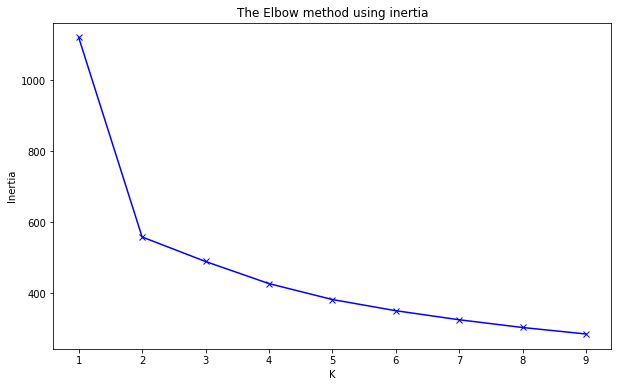

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(range_K, inertia, 'bx-')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.title('The Elbow method using inertia');

The results clearly indicate that the best K is K equal to 2. For now, let's try to use this value and interpret the results.

#### K = 2

In [ ]:
K = 2
k = KMeans(K, init = 'k-means++', random_state = 1)
k.fit(clust_df_norm)
clust_df_norm['k2_means_cluster'] = k.fit_predict(clust_df_norm)
clust_df_norm['k2_means_cluster'] = clust_df_norm['k2_means_cluster'] + 1
summary = clust_df_norm.groupby('k2_means_cluster').agg(['mean', 'std'])
summary

Congestion Factor            ... Safety Index          
                              mean       std  ...         mean       std
k2_means_cluster                              ...                       
1                         0.683130  0.658328  ...    -0.192880  1.037218
2                        -0.718162  0.776265  ...     0.202771  0.930025

[2 rows x 14 columns]

Let's also take a look at the real values. It will help us get a better feeling of what is going on.



In [ ]:
clust_df['k2_means_cluster'] = clust_df_norm['k2_means_cluster']
clust_df.groupby('k2_means_cluster').agg(['mean', 'std'])

Congestion Factor            ... Safety Index           
                              mean       std  ...         mean        std
k2_means_cluster                              ...                        
1                         0.577434  0.125031  ...    51.678780  15.955986
2                         0.311298  0.147430  ...    57.765256  14.306986

[2 rows x 14 columns]

There are two clear groups, one with **high values of desirable factors** (*Internet Penetration, Purchasing Power Index, GDP per Capita, Health Care Index*) indicating high standard of living and low values of undesirable factors (*Congestion*). The other cluster is characterised by the **opposite**.

In [ ]:
summary = clust_df.groupby('k2_means_cluster').agg(['mean', 'std'])
print('Share of standard deviation in a mean (variability) for each cluster:')
for i in range(0, 14, 2):
  print('\n' + summary.columns[i][0])
  print(abs(summary.iloc[:,i+1]/summary.iloc[:,i]))

Share of standard deviation in a mean (variability) for each cluster:

Congestion Factor
k2_means_cluster
1    0.216529
2    0.473599
dtype: float64

Internet Penetration
k2_means_cluster
1    0.306357
2    0.111827
dtype: float64

Purchasing Power Index
k2_means_cluster
1    0.372955
2    0.208447
dtype: float64

GDP per Capita (USD)
k2_means_cluster
1    0.720870
2    0.262296
dtype: float64

Health Care Index
k2_means_cluster
1    0.150992
2    0.090145
dtype: float64

Cost of Living Index
k2_means_cluster
1    0.676271
2    0.642174
dtype: float64

Safety Index
k2_means_cluster
1    0.308753
2    0.247675
dtype: float64


We can observe that the cluster represented by well developed cities has **less variability for almost all of the features**. What is also worth noting, is that the cluster of less developed cities has exceptionally **high standard deviation for GDP column**. This can possibly mean that in this cluster there are **both poor but also wealthy** cities that are still **not able to provide high standard of living** for all of their citizens.  
The Cost of Living Index has also a high standard deviation which would mean that this feature is not the most important while determing the clusters.


Below presented are cities with the highest GDP per Capita in the cluster representing cities with lower standard of living. We can see that although they have relatively high GDP (the mean in this cluster is only around 15 000 USD), they still have rlatively low values of *Purchasing Power Index*, *Safety Index* or *Internet Penetration* and high values of Congestion and that's why they are not a part of the other cluster.

In [ ]:
high_GDP_idx = clust_df[clust_df['k2_means_cluster'] == 1]['GDP per Capita (USD)'].sort_values(ascending = False)[:10].index
clust_df.loc[high_GDP_idx,:]

Congestion Factor  ...  k2_means_cluster
Country    City                             ...                  
Slovakia   Bratislava             0.486024  ...                 1
Italy      Rome                   0.568123  ...                 1
Russia     Moscow                 0.758125  ...                 1
Argentina  Buenos Aires           0.621238  ...                 1
Brazil     Brasilia               0.371569  ...                 1
Kazakhstan Almaty                 0.487173  ...                 1
Portugal   Lisbon                 0.510170  ...                 1
Greece     Athens                 0.493254  ...                 1
Chile      Santiago               0.655245  ...                 1
Poland     Warsaw                 0.584538  ...                 1

[10 rows x 8 columns]

We will visualize the means, both for standardized and real values. For the second plot **we dropped the GDP column** because of its range of values that would ruin the graph.

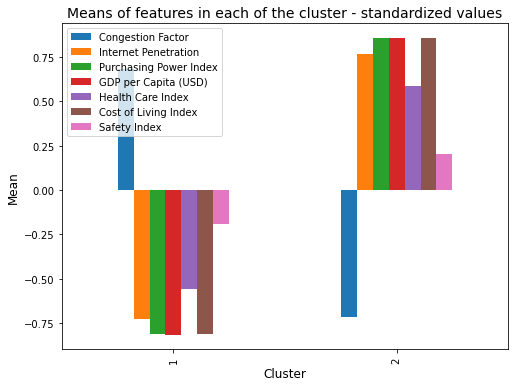

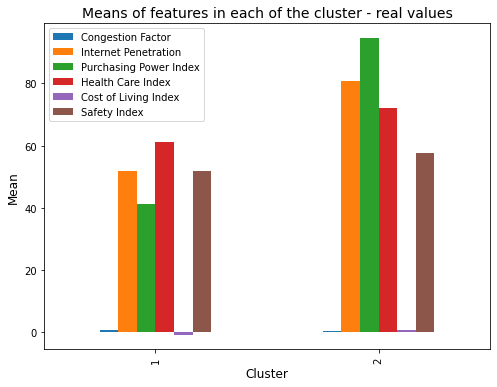

In [ ]:
# visualize standardised values
clust_df_norm.groupby('k2_means_cluster').mean().plot(kind = 'bar', figsize=(8, 6))
plt.title('Means of features in each of the cluster - standardized values', fontsize = 14)
plt.xlabel('Cluster', fontsize = 12)
plt.ylabel('Mean', fontsize = 12);

# visualize real values
clust_df.drop('GDP per Capita (USD)', axis = 1).groupby('k2_means_cluster').mean().plot(kind = 'bar', figsize=(8, 6))
plt.title('Means of features in each of the cluster - real values', fontsize = 14)
plt.xlabel('Cluster', fontsize = 12)
plt.ylabel('Mean', fontsize = 12);

As said before, one cluster is characterized by high values of desirable factors (*Internet Penetration, Purchasing Power Index, GDP per Capita, Health Care Index*) indicating high standard of living and low values of undesirable factors (*Congestion*). The other cluster is characterised by the opposite. The biggest difference seems to lay in the *Purchasing Power Index*. Even though the Costs Of Living are definitely lower for the first cluster, the citizens of those cities are still **not able to buy as many goods or services as citizens in the second cluster** and that's why their overall standard of living is lower.

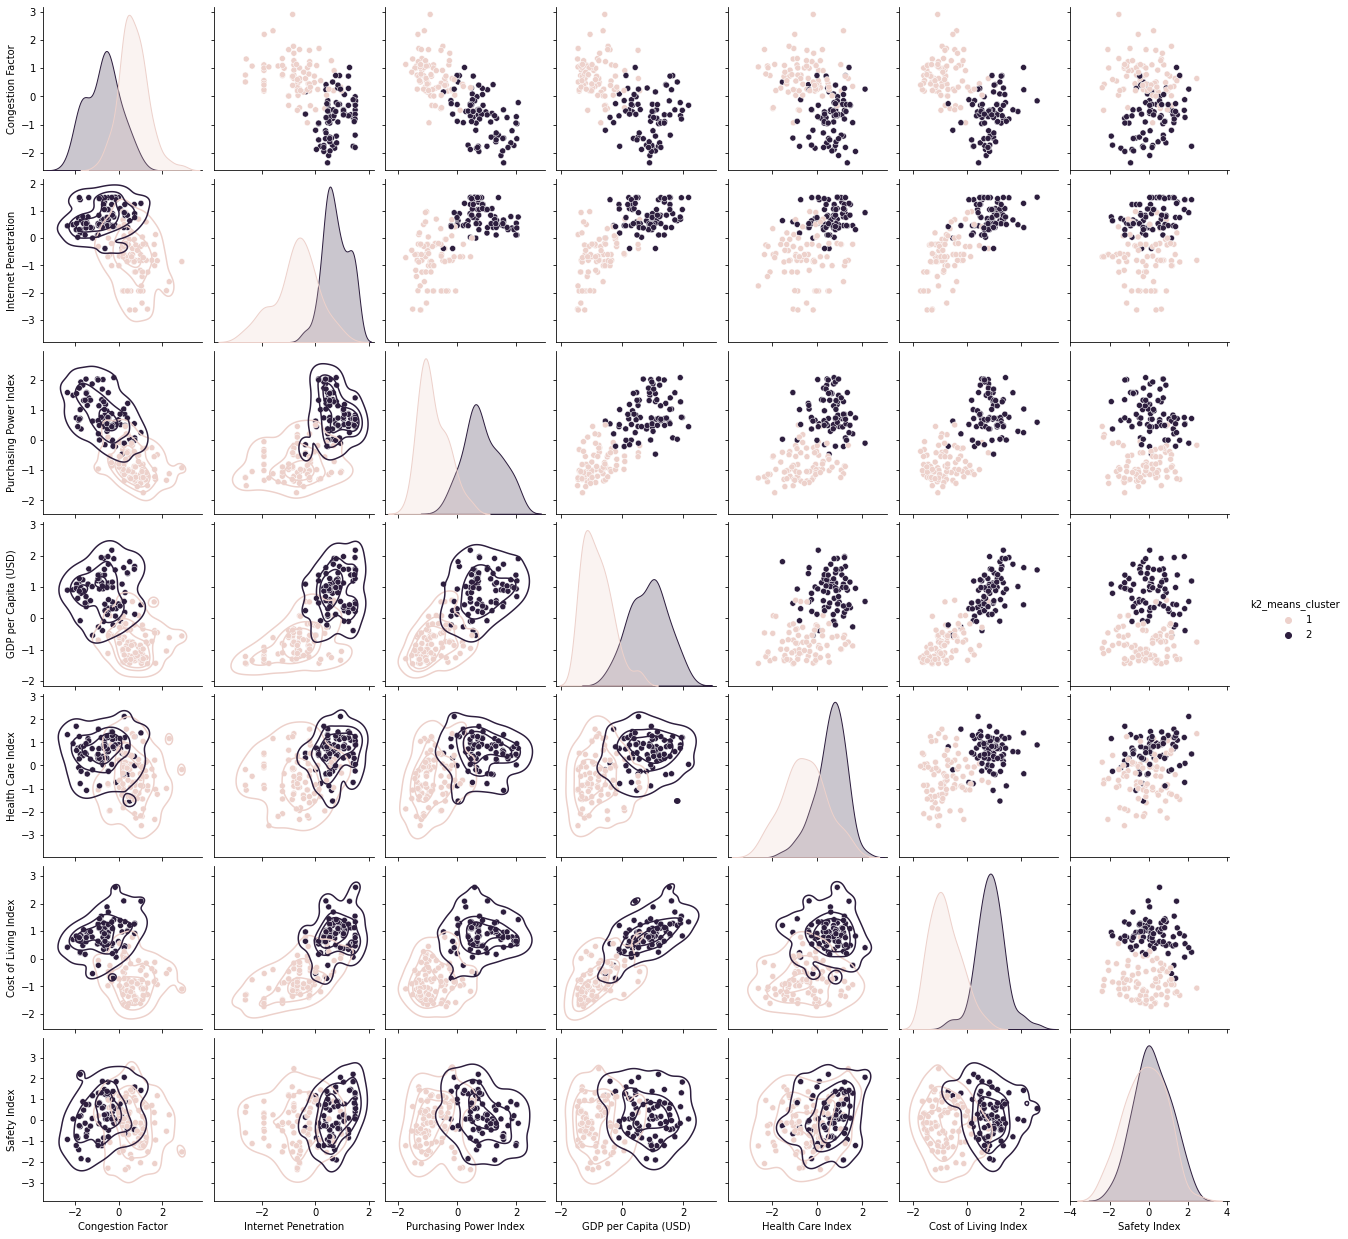

In [ ]:
g = sns.pairplot(clust_df_norm, hue = 'k2_means_cluster')
g.map_lower(sns.kdeplot, levels = 4, color = ".2")

We can see that for K = 2, the clusters are quite well separated and in most cases do not overlap too much.
We can also point that the shape of clusters is rather **spherical** which is characteristic for K-means algorithm. It works in a way that it places a circle at the center of each cluster, with a radius defined by the most distant point in the cluster.

We also wanted to show what cities exactly belong to each of the cluster. However, we thought it would be easier to understand this division by considering countries. It is illustrated by a word cloud below.

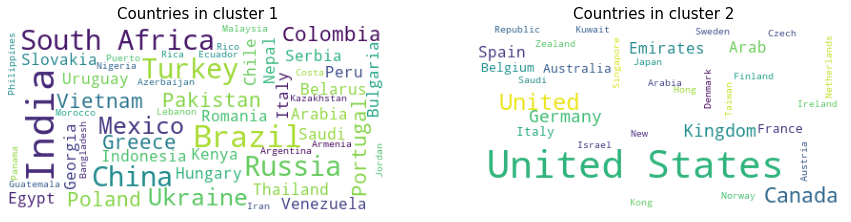

In [ ]:
from wordcloud import WordCloud

cluster1 = clust_df_norm[clust_df_norm.k2_means_cluster == 1].index.get_level_values(0).tolist()
cluster2 = clust_df_norm[clust_df_norm.k2_means_cluster == 2].index.get_level_values(0).tolist()

string1 = ''
for i in range(len(cluster1)):
  string1 = string1 + ' ' + cluster1[i]

string2 = ''
for i in range(len(cluster2)):
  string2 = string2 + ' ' + cluster2[i]

cluster1 = WordCloud(background_color="white", max_font_size=40, relative_scaling=.5).generate(string1)
cluster2 = WordCloud(background_color="white", max_font_size=40, relative_scaling=.5).generate(string2)

plt.figure(figsize = (15, 15))
plt.subplot(1, 2, 1)
plt.imshow(cluster1)
plt.axis("off")
plt.title('Countries in cluster 1', fontsize = 15)

plt.subplot(1, 2, 2)
plt.imshow(cluster2)
plt.axis("off")
plt.title('Countries in cluster 2', fontsize = 15);

In [ ]:
print('Number of cities in each cluster:')
clust_df_norm['k2_means_cluster'].value_counts()

Number of cities in each cluster:


1    82
2    78
Name: k2_means_cluster, dtype: int64

In cluster of cities with higher standard of living there are a lot of cities from Unites States, Western Europe and the region of Asian tigers. The other cluster includes cities from Africa, Middle-East, Asia and Eastern Europe, which are characterized by lower GDP, worse health care and higher congestion.  
Although from this word clouds it may seem that one of the clusters is less represented, it is because most of the cities are in United States. The value count reveals that the clusters are not imbalanced.

#### K = 3

Even though the Silhouette index points that K = 2 is the optimal value of this hyperparameter, let's see what would the clustering look like for K = 3. Especially, we are interested in checking **whether one of the clusters will split up into two better distinguishable groups**. We expect it will be the one with **higher variability** among the features.

In [ ]:
np.random.RandomState(1)
K = 3
k = KMeans(K, init = 'k-means++', random_state = 333)
k.fit(clust_df)
#X_clusters = X.copy()
clust_df_norm['k3_means_cluster'] = k.fit_predict(clust_df_norm)
clust_df_norm['k3_means_cluster'] = clust_df_norm['k3_means_cluster'] + 1
clust_df_norm.groupby('k3_means_cluster').agg(['mean', 'std'])

Congestion Factor            ... k2_means_cluster          
                              mean       std  ...             mean       std
k3_means_cluster                              ...                           
1                         0.797783  0.626040  ...          1.00000  0.000000
2                        -0.724141  0.779546  ...          2.00000  0.000000
3                         0.542731  0.681196  ...          1.02439  0.156174

[3 rows x 16 columns]

Summary for real values:

In [ ]:
clust_df['k3_means_cluster'] = clust_df_norm['k3_means_cluster']
clust_df.drop('k2_means_cluster', axis = 1).groupby('k3_means_cluster').agg(['mean', 'std'])

Congestion Factor            ... Safety Index           
                              mean       std  ...         mean        std
k3_means_cluster                              ...                        
1                         0.599209  0.118899  ...    39.239524  10.065788
2                         0.310162  0.148053  ...    57.530260  14.248475
3                         0.550769  0.129374  ...    65.011220   9.035895

[3 rows x 14 columns]

In [ ]:
# Please, change the number in the condition to the number of cluster represented by the cities with the highest standard of living.
# To identify this cluster, take a look at the Congestion Factor feature in the summary above.
# The mean of this feature for the "best" cluster should be around 0.3 (the lowest).
clust_df[clust_df.k3_means_cluster != 2].k2_means_cluster.value_counts()

1    82
2     1
Name: k2_means_cluster, dtype: int64

By comparing these summary tables with the summary for K = 2 we can see that the statistics of cluster represented by cities with higher standard of living (in this case cluster number 2) remained nearly **untouched**. Additionally, the above cell proves that increasing the value of K by 1 resulted in **splitting up mainly the cluster represented by cities with worse standard of living**.  
The biggest difference between them lies in a **Safety Index** features. It is true for every run of this algorithm, which means this division is not random.

Let's plot the mean values of features for each cluster.

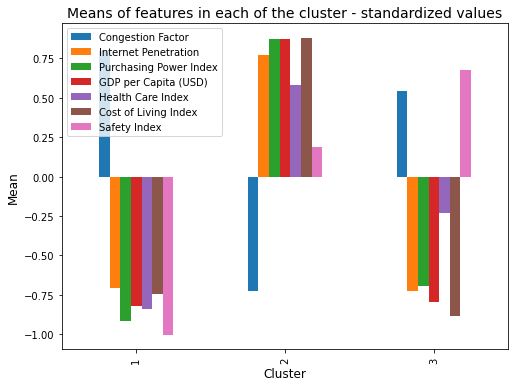

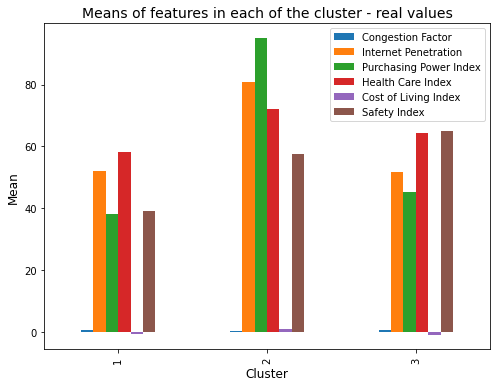

In [ ]:
clust_df_norm.drop('k2_means_cluster', axis = 1).groupby('k3_means_cluster').mean().plot(kind = 'bar', figsize=(8, 6));
plt.title('Means of features in each of the cluster - standardized values', fontsize = 14)
plt.xlabel('Cluster', fontsize = 12)
plt.ylabel('Mean', fontsize = 12);

clust_df.drop(['GDP per Capita (USD)', 'k2_means_cluster'], axis = 1).groupby('k3_means_cluster').mean().plot(kind = 'bar', figsize=(8, 6));
plt.title('Means of features in each of the cluster - real values', fontsize = 14)
plt.xlabel('Cluster', fontsize = 12)
plt.ylabel('Mean', fontsize = 12);

The biggest difference between the "new" clusters (1 & 3 in our case) lies in the *Safety Index* feature.  
However, the below pairplot shows that although the cluster with cities with high standard of living (nr 2) can be easily distinguished, the remaining two (1 & 3) are too overlapping, making the result of K-means with K = 3 a worse grouping then the result for K = 2.

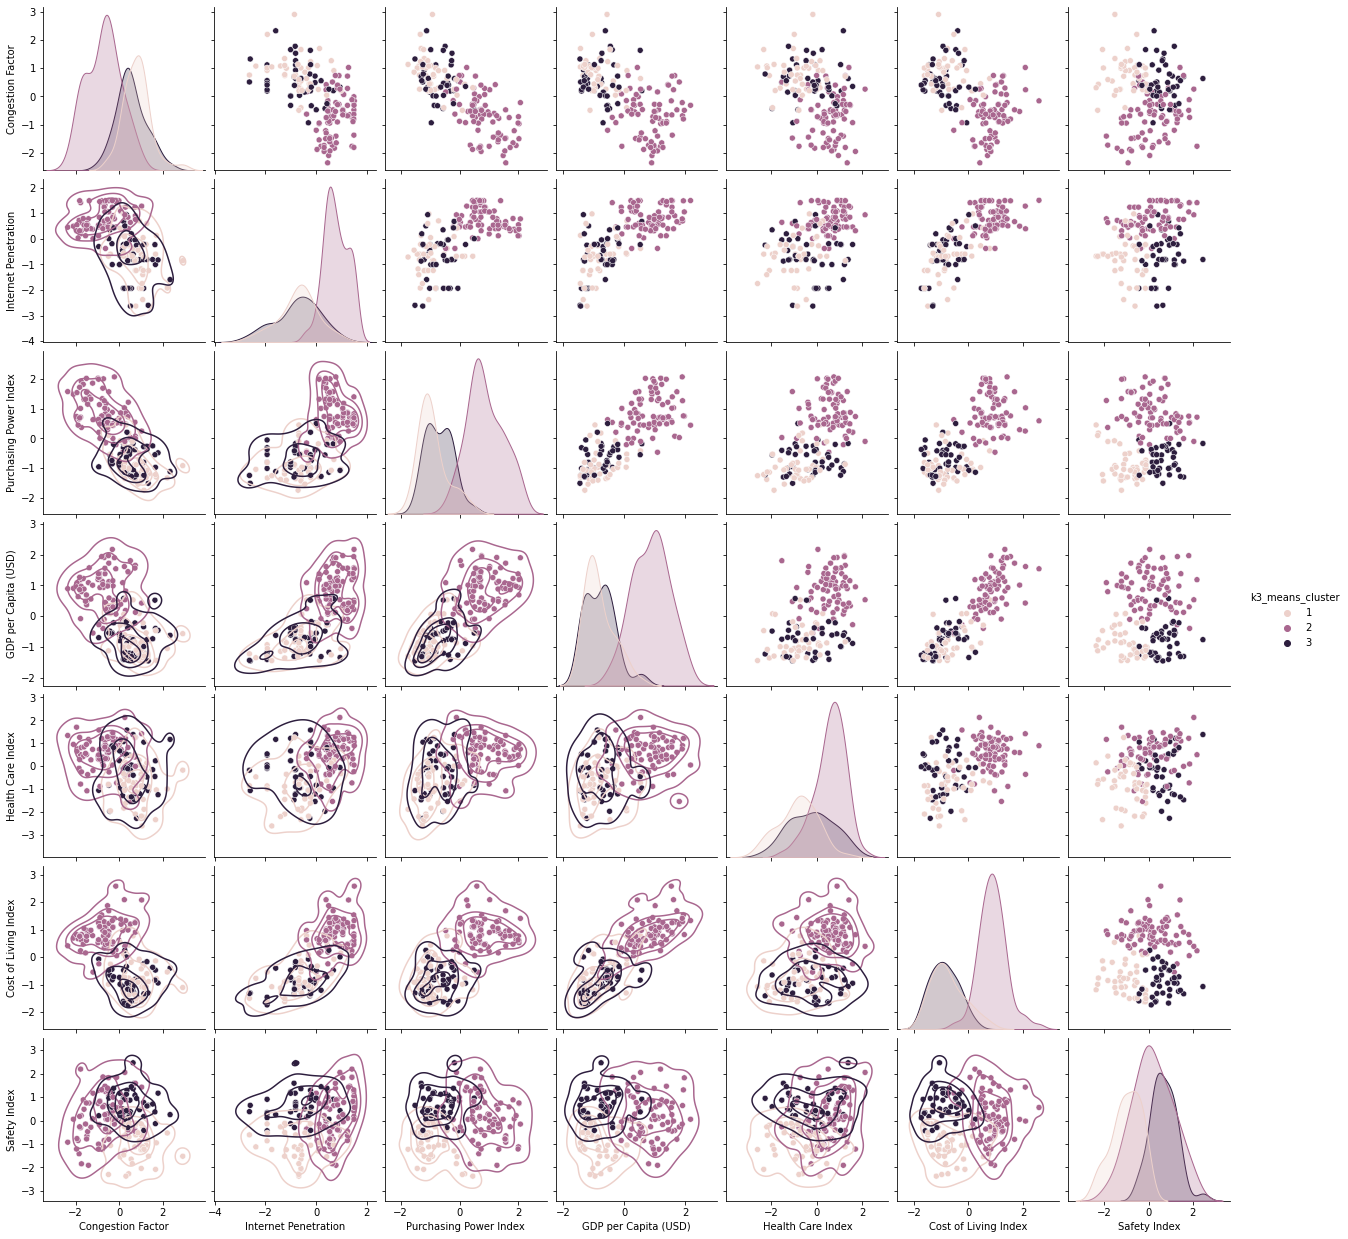

In [ ]:
g = sns.pairplot(clust_df_norm.drop('k2_means_cluster', axis = 1), hue = 'k3_means_cluster')
g.map_lower(sns.kdeplot, levels=4, color=".2")

A chunk below outputs which countries belong to which cluster.

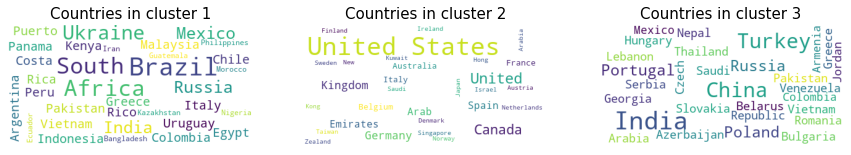

In [ ]:
cluster1 = clust_df_norm[clust_df_norm.k3_means_cluster == 1].index.get_level_values(0).tolist()
cluster2 = clust_df_norm[clust_df_norm.k3_means_cluster == 2].index.get_level_values(0).tolist()
cluster3 = clust_df_norm[clust_df_norm.k3_means_cluster == 3].index.get_level_values(0).tolist()

string1 = ''; string2 = ''; string3 = ''
for i in range(len(cluster1)):
  string1 = string1 + ' ' + cluster1[i]
for i in range(len(cluster2)):
  string2 = string2 + ' ' + cluster2[i]
for i in range(len(cluster3)):
  string3 = string3 + ' ' + cluster3[i]

cluster1 = WordCloud(background_color="white", max_font_size=40, relative_scaling=.5).generate(string1)
cluster2 = WordCloud(background_color="white", max_font_size=40, relative_scaling=.5).generate(string2)
cluster3 = WordCloud(background_color="white", max_font_size=40, relative_scaling=.5).generate(string3)

plt.figure(figsize = (15, 15))
plt.subplot(1, 3, 1)
plt.imshow(cluster1)
plt.axis("off")
plt.title('Countries in cluster 1', fontsize = 15)

plt.subplot(1, 3, 2)
plt.imshow(cluster2)
plt.axis("off")
plt.title('Countries in cluster 2', fontsize = 15);

plt.subplot(1, 3, 3)
plt.imshow(cluster3)
plt.axis("off")
plt.title('Countries in cluster 3', fontsize = 15);

### Hierarchical clustering

Hierarchical clustering is a method of cluster analysis which seeks to build a **hierarchy of clusters**. In other words, it arranges the data in a nested sequence of partitions organised as a hierarchy. The **bottom** of this hierarchy is a finest partition (each observation is in a unique cluster). The **top**, on the other hand, is the coarsest possible partition (every observation is in the same cluster).  
Strategies for hierarchical clustering generally fall into two types: **agglomerative** and **divisive**. The *linkage* function that we will use is a part of the **`scipy`** package and implemets the agglomerative (bottom-top approach) method.

As a default distance metric it uses an **Euclidean distance**.
As a linkage method we decided to use **Ward's method**, which uses the Ward variance minimization algorithm. It works by finding at each step the pair of clusters that leads to **minimum increase in total within-cluster variance** after merging.

In [ ]:
np.random.RandomState(1);

In the below dendrogram our cutoff value is 20, which results in a division in two clusters.

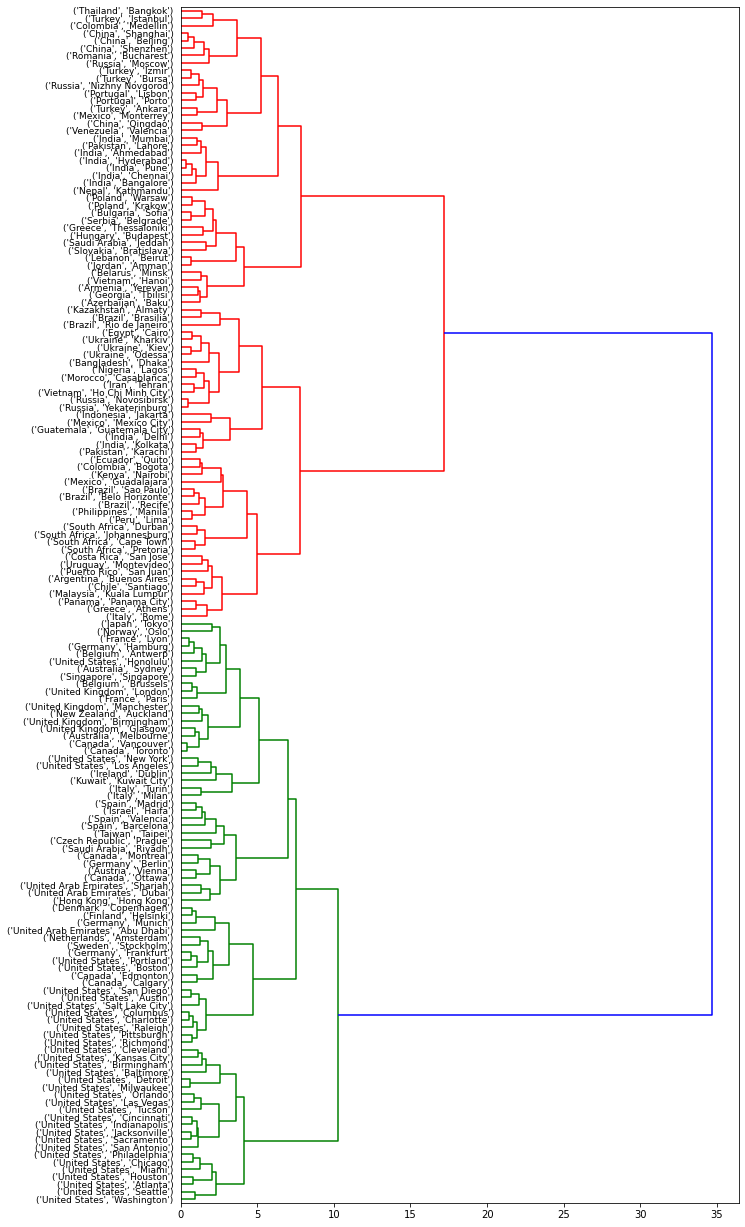

In [ ]:
linked = linkage(clust_df_norm, 'ward')
labelList = clust_df_norm.index.tolist()
plt.figure(figsize=(10, 22))
dendrogram(linked,
            orientation='right',
            labels=labelList,
            color_threshold = 20,
            distance_sort='descending',
            show_leaf_counts=True,
            leaf_font_size = 9);

clust_df['h2_cluster'] = fcluster(linked, 20, criterion = 'distance')

Here, we colour the dendrogram so that it shows three clusters.

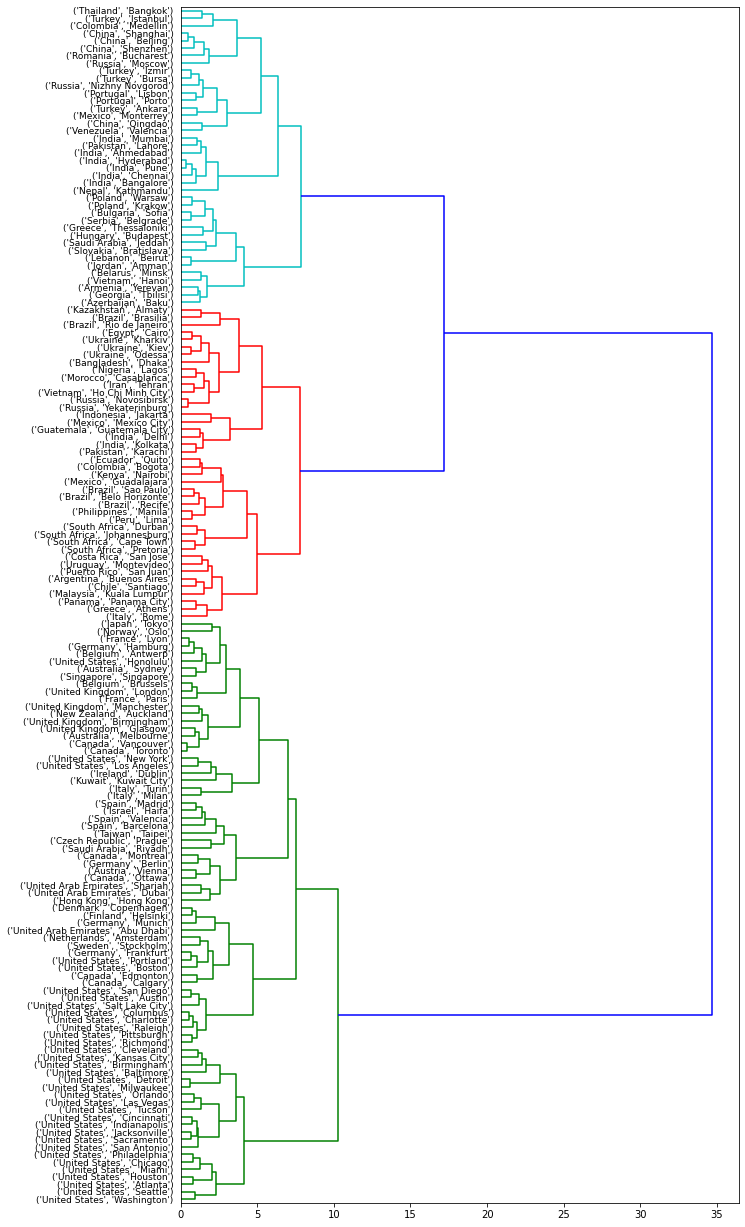

In [ ]:
plt.figure(figsize=(10, 22))
dendrogram(linked,
            orientation='right',
            labels=labelList,
            color_threshold = 15,
            distance_sort='descending',
            show_leaf_counts=True,
            leaf_font_size = 9);

clust_df['h3_cluster'] = fcluster(linked, 12, criterion = 'distance')

Let's take a look at the summaries of both clusterings:

In [ ]:
clust_df.groupby('h2_cluster').agg(['mean', 'std'])

Congestion Factor            ... h3_cluster          
                        mean       std  ...       mean       std
h2_cluster                              ...                     
1                   0.311298  0.147430  ...   1.000000  0.000000
2                   0.577434  0.125031  ...   2.487805  0.502927

[2 rows x 20 columns]

In [ ]:
clust_df.groupby('h3_cluster').agg(['mean', 'std'])

Congestion Factor            ... h2_cluster     
                        mean       std  ...       mean  std
h3_cluster                              ...                
1                   0.311298  0.147430  ...          1  0.0
2                   0.599209  0.118899  ...          2  0.0
3                   0.554570  0.128683  ...          2  0.0

[3 rows x 20 columns]

We will again use the word cloud to clearly present the countries in each cluster.

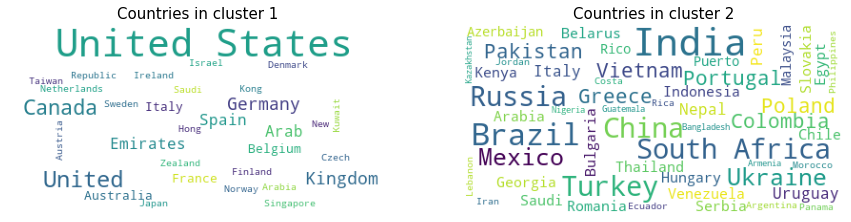

In [ ]:
cluster1 = clust_df_norm[clust_df.h2_cluster == 1].index.get_level_values(0).tolist()
cluster2 = clust_df_norm[clust_df.h2_cluster == 2].index.get_level_values(0).tolist()
string1 = ''; string2 = ''
for i in range(len(cluster1)):
  string1 = string1 + ' ' + cluster1[i]
for i in range(len(cluster2)):
  string2 = string2 + ' ' + cluster2[i]
cluster1 = WordCloud(background_color="white", max_font_size=40, relative_scaling=.5).generate(string1)
cluster2 = WordCloud(background_color="white", max_font_size=40, relative_scaling=.5).generate(string2)

plt.figure(figsize = (15, 15))
plt.subplot(1, 2, 1)
plt.imshow(cluster1)
plt.axis("off")
plt.title('Countries in cluster 1', fontsize = 15)

plt.subplot(1, 2, 2)
plt.imshow(cluster2)
plt.axis("off")
plt.title('Countries in cluster 2', fontsize = 15);

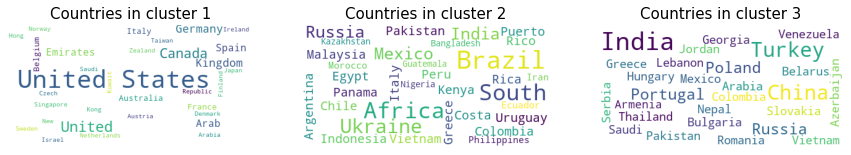

In [ ]:
cluster1 = clust_df_norm[clust_df.h3_cluster == 1].index.get_level_values(0).tolist()
cluster2 = clust_df_norm[clust_df.h3_cluster == 2].index.get_level_values(0).tolist()
cluster3 = clust_df_norm[clust_df.h3_cluster == 3].index.get_level_values(0).tolist()
string1 = ''; string2 = ''; string3 = ''
for i in range(len(cluster1)):
  string1 = string1 + ' ' + cluster1[i]
for i in range(len(cluster2)):
  string2 = string2 + ' ' + cluster2[i]
for i in range(len(cluster3)):
  string3 = string3 + ' ' + cluster3[i]
cluster1 = WordCloud(background_color="white", max_font_size=40, relative_scaling=.5).generate(string1)
cluster2 = WordCloud(background_color="white", max_font_size=40, relative_scaling=.5).generate(string2)
cluster3 = WordCloud(background_color="white", max_font_size=40, relative_scaling=.5).generate(string3)

plt.figure(figsize = (15, 15))
plt.subplot(1, 3, 1)
plt.imshow(cluster1)
plt.axis("off")
plt.title('Countries in cluster 1', fontsize = 15)
plt.subplot(1, 3, 2)
plt.imshow(cluster2)
plt.axis("off")
plt.title('Countries in cluster 2', fontsize = 15);
plt.subplot(1, 3, 3)
plt.imshow(cluster3)
plt.axis("off")
plt.title('Countries in cluster 3', fontsize = 15);

**Both the resulting descriptive statistics and the word clouds are practically the same as the ones for K-means algorithm for 2 as well as for 3 clusters**.

### Summary

To sum up, we discovered two clear groups when clustering cities based on factors influencing our standard of living. The division on three clusters was definitely worse which was proved by the visualisation (which showed us that the clusters are too overlapping). This is why both the Silhouette index and the elbow method pointed that division into two clusters will be the best.  
We learned that having relatively high GDP per Capita does not necessarily is equal to high standard of living. We showed that there are cities, especially in Southern America and in some regions of Europe, that although they are able to generate high gross domestic product, they fail to provide safety, connection to the Internet or good access to health care.

# Prediction, part I

We use the below function to make the evaluation process clear and concise.
Among the many possible metrics to use for this purpose we turned to the most popular ones:
* **$R^2$**, which tells how much of the variability in the dependent variable is explained by the model, and its **adjusted** version, which adjusts for the number of terms used. It penalizes the scientist for adding variables that are not useful and is always lower than $R^2$. The goal is to have the adjusted $R^2$ as close to the $R^2$ as possible.
* **Mean squared error**, which measures the mean of squared difference between predicted and real value.
* **Root mean square error**, which measures the average magnitute of the error.
* **Mean absolute error**, which measures the average magnitude of the errors, without considering their direction.

In [ ]:
def evaluate(y_test, y_pred, m):
  # R^2
  r_squared = max(0, 1 - np.sum((y_test-y_pred)**2) / np.sum((y_test - np.mean(y_test))**2))
  print("R^2:     ", round(r_squared, 3))
  # Adjusted R^2
  print("Adj. R^2:", round(1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-m-1), 3))
  # MSE
  print("MSE:     ", round(np.mean((y_pred - y_test)**2),3))
  # RMSE
  print("RMSE:    ", round(np.sqrt(np.mean((y_pred - y_test)**2)), 3))
  # MAE
  print("MAE:     ", round(np.mean(np.abs(y_pred - y_test)), 3))

Based on a correlation with the target variable we initially chose 17 variables (stored in a *cols* list).
After investigating the correlation between independent variables we decided to drop some of them (obtaining *cols_after* list) in the following way:

* *Restaurant* and *Grocery Index* (correlate too much with *Cost of Living Index*)
* *Development Factor* (correlates too much with *GDP*)
* *Internet Penetration* (correlates too much with *Digital Penetration*)
* *Car Modeshare (%)* (correlates too much with *Congestion* and has lower correlation with the target)
* *Digital Penetration* (correlates to much with *GDP*)
* *Local Purchasing Power Index* (correlates too much with *GDP*)
* *Cost of Living Index* (correlates too much with *GDP*).  

By doing this we would like to reduce the complexity of the model and reduce the gap between $R^2$ and adjusted $R^2$.

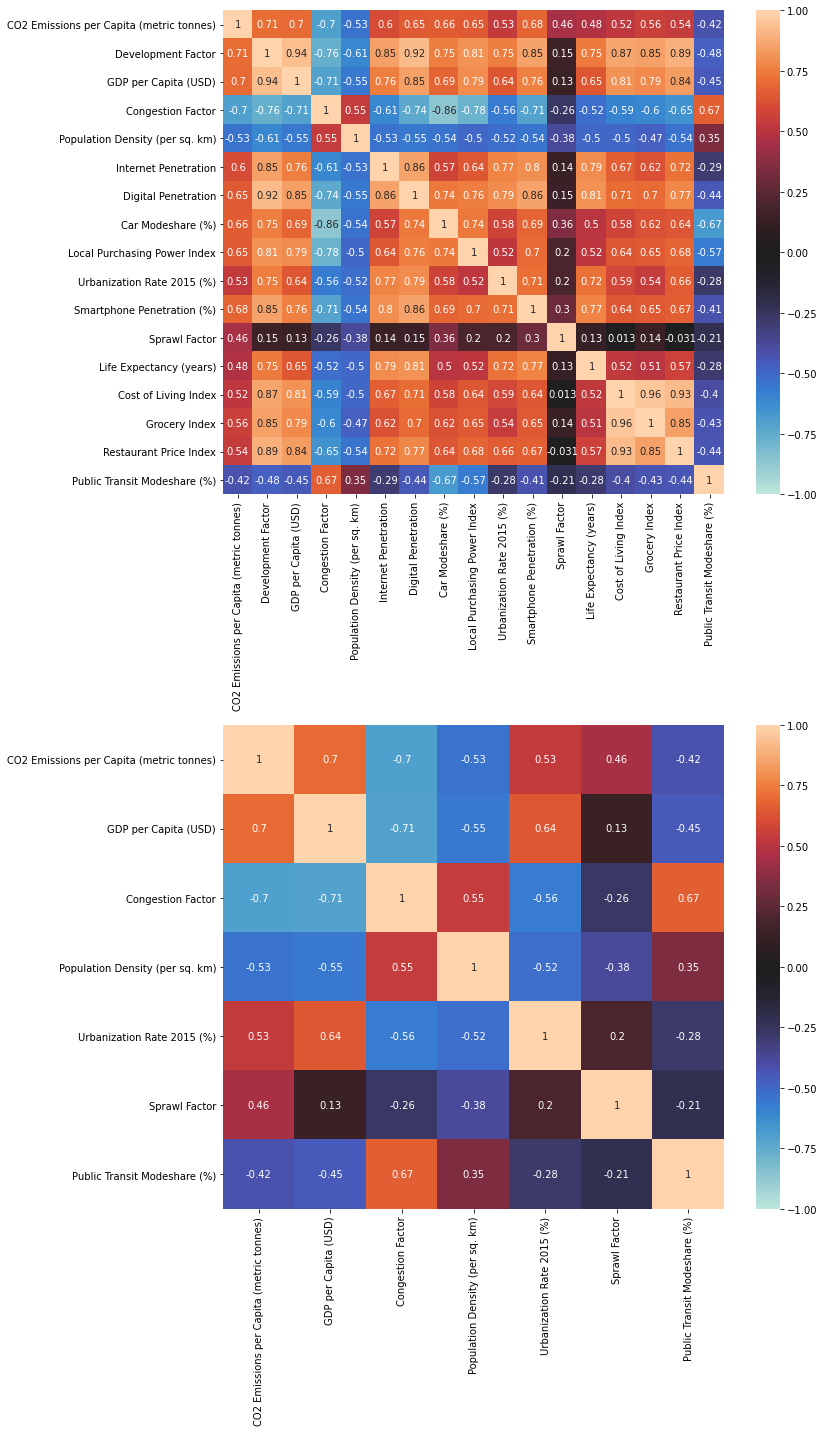

In [ ]:
cols = ['CO2 Emissions per Capita (metric tonnes)', 'Development Factor', 'GDP per Capita (USD)', 'Congestion Factor', 'Population Density (per sq. km)',
       'Internet Penetration', 'Digital Penetration', 'Car Modeshare (%)', 'Local Purchasing Power Index', 'Urbanization Rate 2015 (%)',
       'Smartphone Penetration (%)', 'Sprawl Factor', 'Life Expectancy (years)', 'Cost of Living Index', #'Walking Modeshare (%)',
        'Grocery Index', 'Restaurant Price Index', 'Public Transit Modeshare (%)']

plt.figure(figsize = (12, 20))

plt.subplot(2, 1, 1)
sns.heatmap(df_clean[cols].corr(), vmin = -1, center = 0, vmax = 1, annot = True)
plt.plot("Correlation for all 17 features")

cols_after = ['CO2 Emissions per Capita (metric tonnes)', 'GDP per Capita (USD)', 'Congestion Factor', 'Population Density (per sq. km)',
        'Urbanization Rate 2015 (%)', 'Sprawl Factor', 'Public Transit Modeshare (%)']#'Walking Modeshare (%)']

plt.subplot(2, 1, 2)
sns.heatmap(df[cols_after].corr(), vmin = -1, center = 0, vmax = 1, annot = True)
plt.plot("Correlation for features after selection")
plt.tight_layout()

## Linear Regression

We want to fit a simple linear regression model using all 17 variables (*cols*) and compare the results with the the model with reduced number of features (*cols_after*).  
To do so, we split the data accordingly to the project description and the standardise.

In [ ]:
cols = ['Development Factor', 'GDP per Capita (USD)', 'Congestion Factor', 'Population Density (per sq. km)',
       'Internet Penetration', 'Digital Penetration', 'Car Modeshare (%)', 'Local Purchasing Power Index', 'Urbanization Rate 2015 (%)',
       'Smartphone Penetration (%)', 'Sprawl Factor', 'Life Expectancy (years)', 'Cost of Living Index', #'Walking Modeshare (%)',
        'Grocery Index', 'Restaurant Price Index', 'Public Transit Modeshare (%)']
X = df[cols]
y = df['CO2 Emissions per Capita (metric tonnes)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, shuffle = False)
X_train = (X_train - np.mean(X_train))/np.std(X_train)
X_test = (X_test - np.mean(X_test))/np.std(X_test)

lm = LinearRegression()
lm.fit(X_train, y_train)
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)
print("Linear regression with all 17 variables, TRAINING RESULTS:")
evaluate(y_train, y_pred_train, X_train.shape[1])
print("\nLinear regression with all 17 variables, TEST RESULTS:")
evaluate(y_test, y_pred_test, X_train.shape[1])

cols_after = ['GDP per Capita (USD)', 'Congestion Factor', 'Population Density (per sq. km)',
        'Urbanization Rate 2015 (%)', 'Sprawl Factor', 'Public Transit Modeshare (%)']#'Walking Modeshare (%)', 
X = df[cols_after]
y = df['CO2 Emissions per Capita (metric tonnes)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, shuffle = False)
X_train = (X_train - np.mean(X_train))/np.std(X_train)
X_test = (X_test - np.mean(X_test))/np.std(X_test)

lm = LinearRegression()
lm.fit(X_train, y_train)

y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)
print("\nLinear regression after manual feature selection, TRAINING RESULTS:")
evaluate(y_train, y_pred_train, X_train.shape[1])
print("\nLinear regression after manual feature selection, TEST RESULTS:")
evaluate(y_test, y_pred_test, X_train.shape[1])

Linear regression with all 17 variables, TRAINING RESULTS:
R^2:      0.749
Adj. R^2: 0.731
MSE:      10.032
RMSE:     3.167
MAE:      2.312

Linear regression with all 17 variables, TEST RESULTS:
R^2:      0.529
Adj. R^2: 0.415
MSE:      23.874
RMSE:     4.886
MAE:      3.236

Linear regression after manual feature selection, TRAINING RESULTS:
R^2:      0.712
Adj. R^2: 0.705
MSE:      11.482
RMSE:     3.389
MAE:      2.413

Linear regression after manual feature selection, TEST RESULTS:
R^2:      0.606
Adj. R^2: 0.575
MSE:      19.997
RMSE:     4.472
MAE:      2.821


It can be observed that the $R^2$ for the less complex model has improved even though we reduced the number of features by 10 and the errors on the testing set are lower. Additionally, what's more important, we gained a high increase in the value of adjusted $R^2$, reducing the gap between $R^2$, which means that the removed features were indeed not important for explaining the target.  
Now let's plot the predicted values versus observed.

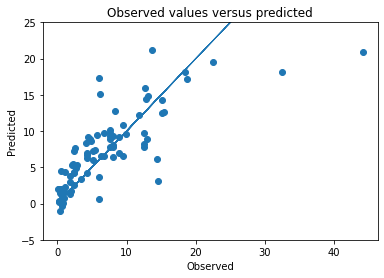

In [ ]:
plt.scatter(y_test, y_pred_test)
plt.plot(y_test,  y_test, linewidth = 1)
plt.ylim([-5, 25])
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("Observed values versus predicted");

Based on this plot we can draw some conclusions.  
What first catches the eye, is the fact that the residuals are not heteroskedastic, meaning that the error is not constant across various levels of the dependent variable and increases as the value of the target increases. From this plot it is clear that the model does a poor job when predicting large values (> 15), we can even say that it is actually random. This can be due to the fact that the larger values are underrepresented in the training set (see the boxplot below). 
Secondly, the relationship does not really seem to be linear. Finally, some of the predictions are negative (while we would prefer to get only positive ones). This is why in the next step we will consider **logarithmic transformation** applied on the target.

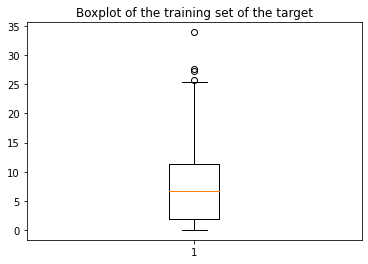

In [ ]:
plt.boxplot(y_train)
plt.title("Boxplot of the training set of the target");

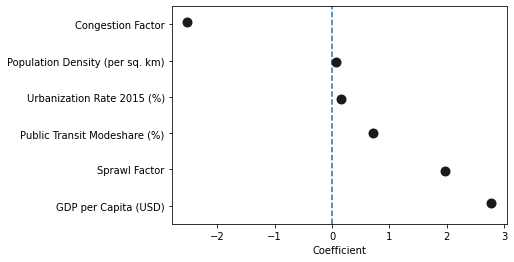

In [ ]:
summary = pd.DataFrame(data = lm.coef_, index = X_train.columns, columns = ['Coefficient'])
summary = summary.sort_values(by = 'Coefficient')
sns.stripplot(y = summary.index.tolist(), x = summary['Coefficient'], color = ".1", size = 10)
plt.axvline(0, linestyle = '--');

From this plot we can easily see that one-unit increase of the *Congestion Factor* feature negatively impacts the target (while holding other variables constant), while one-unit increases in the remaining features will result in an increase of CO2 emissions. Among them the biggest impact have *GDP per Capita* and *Sprawl Factor*. At the same time we must keep in mind that the assumptions of OLS were not met, so the coefficients can be biased and relatively far from the true population values.  
We can for example observe that Population Density has very low although positive weight, which does not correspond to the sign of linear correlation with the target variable.

Mean of residuals: 0.3387440436973489
Pvalue of Shapiro-Wilk normality test: 5.733360897153261e-09


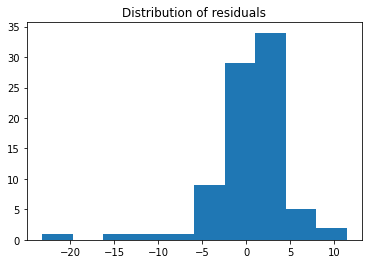

In [ ]:
errors = y_pred_test - y_test
print("Mean of residuals:", np.mean(errors))
from scipy.stats import shapiro
print("Pvalue of Shapiro-Wilk normality test:", shapiro(errors)[1])
plt.hist(errors);
plt.title('Distribution of residuals');

The above chunk proves that the mean of residuals is definitely not equal to zero. Furthermore, the distribution of errors is not normal as it appears from the histogram and p-value of Shapiro-Wilk statistical test for normality is close to zero. It means that we should reject the null hypothesis stating that the data was drawn from a Gaussian distribution.

### Logarithmic transformation

We would like to apply logarithmic transformation to the target variable as it is currently positively skew. By doing this we would like to transform it into one that is more approximately normal. We decided to use `np.log1p` function, which applies $\log(1 + y)$ function to the data, as it contains zeroes.  
We then back-transform the predictions of the dependent variable to be able to compare the results with a previous model.

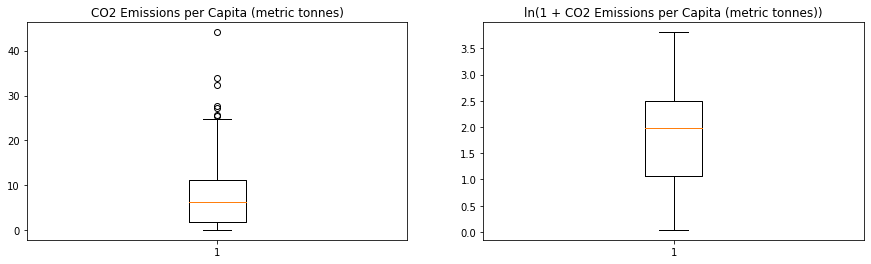

In [ ]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.boxplot(df['CO2 Emissions per Capita (metric tonnes)'])
plt.title("CO2 Emissions per Capita (metric tonnes)")
plt.subplot(1, 2, 2)
plt.boxplot(np.log1p(df['CO2 Emissions per Capita (metric tonnes)']))
plt.title("ln(1 + CO2 Emissions per Capita (metric tonnes))");

In [ ]:
cols_after = ['GDP per Capita (USD)', 'Congestion Factor', 'Population Density (per sq. km)',
        'Urbanization Rate 2015 (%)', 'Sprawl Factor', 'Public Transit Modeshare (%)']#'Walking Modeshare (%)', 
X = df[cols_after]
y = df['CO2 Emissions per Capita (metric tonnes)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, shuffle = False)
X_train = (X_train - np.mean(X_train))/np.std(X_train)
X_test = (X_test - np.mean(X_test))/np.std(X_test)

y_train_log = np.log1p(y_train)
#y_test = np.log1p(y_test)

lm = LinearRegression()
lm.fit(X_train, y_train_log)

y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)
print("\nLinear regression after manual feature selection, TRAINING RESULTS:")
evaluate(y_train, np.exp(y_pred_train)-1, X_train.shape[1])

print("\nLinear regression after manual feature selection, TEST RESULTS:")
evaluate(y_test, np.exp(y_pred_test)-1, X_train.shape[1])


Linear regression after manual feature selection, TRAINING RESULTS:
R^2:      0.642
Adj. R^2: 0.633
MSE:      14.275
RMSE:     3.778
MAE:      2.667

Linear regression after manual feature selection, TEST RESULTS:
R^2:      0.605
Adj. R^2: 0.574
MSE:      20.035
RMSE:     4.476
MAE:      2.92


The results after applying the log transformation did not improved. The $R^2$ metrics of the test set are really close to the ones of the previous model but all of the error metrics are higher.  
The mean of residuals is now closer to zero (0.33 for the previous model) but the distribution still isn't likely to be approximately normal.

Mean of residuals: -0.15698426907437932
Pvalue of Shapiro-Wilk normality test: 1.736853050715581e-06


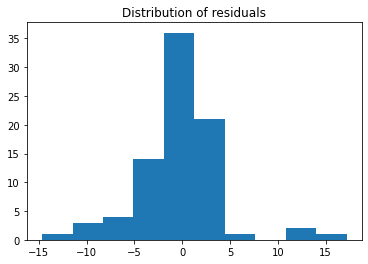

In [ ]:
errors = (np.exp(y_pred_test)-1) - y_test
print("Mean of residuals:", np.mean(errors))
from scipy.stats import shapiro
print("Pvalue of Shapiro-Wilk normality test:", shapiro(errors)[1])
plt.hist(errors);
plt.title('Distribution of residuals');

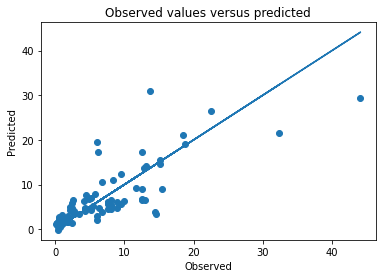

In [ ]:
plt.scatter(y_test, np.exp(y_pred_test)-1)
plt.plot(y_test, y_test)
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("Observed values versus predicted");

In this case the interpretation of coefficients is different of course. Now they inform us of the expected change in logarithm of$\ y$ with respect to a one-unit increase in a given independent variable, holding all other variables at a fixed value. However, if we want to know what happens to the outcome variable itself for a one-unit increase in 
a given feature, we should interpret the **exponentiated regression coefficients**, since exponentiation is the inverse of logarithm function. Here we also substract 1 because the form of the transformation was $\log(1+y)$.

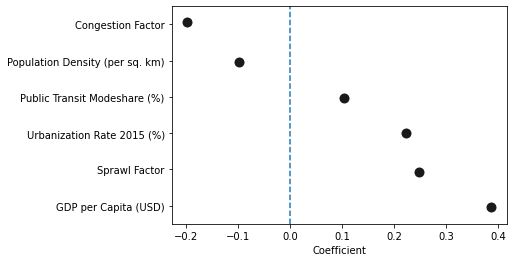

In [ ]:
summary = pd.DataFrame(data = lm.coef_, index = X_train.columns, columns = ['Coefficient'])
summary = (np.exp(summary)-1)
summary = summary.sort_values(by = 'Coefficient')
sns.stripplot(y = summary.index.tolist(), x = summary['Coefficient'], color = ".1", size = 10)
plt.axvline(0, linestyle = '--');

Now we can see that the weight of *Population Density* feature is clearly negative which corresponds to the sign of linear correlation with a target, which was not the case for the first model. It makes sense because areas with low or medium density may not have as effective public transprtaton as cities with high population density. This results in a higher number of people commuting in a separate cars rather than using public transport.  
Again, the *GDP per Capita* feature has the biggest positive impact on CO2 emissions. It is reasonable because the higher the GDP, the more goods and services are being sold. This means increased human activity and production capacity, which often involves carbon dioxide emissions.  
Surprisingly, the sign of *Public Transport Modeshare (%)* is also positive. We would rather expect that higher share of public transport may possibly mean decreased share of car modeshare which in turn means reduced CO2 emissions. According to the model, this is not the case and having more buses does not necessarily mean that people will stop using cars. It may be just a result of the need to accommodate citizens in overpopulated cities for example.

## L1 regularization

In this section we would like to apply L1 regularization for the purpose of feature selection. As this method extends the objective function by the following term: $\dots + \lambda \sum_{j} |w_j|$, it encourages the weight of less important features to go towards zero. We are interested in checking what features (other than the ones that we selected in a previous section based mainly on the correlation (*cols_after*)) will this technique deem as irrelevant, schrinking their coefficients completely to zero.  
In this example we will also consider one of the categorical features - *Typology*, that is why we perform the one-hot encoding by applying `pd.get_dummies` function.  
We decide to stick to the log transformation.

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

In [ ]:
typologies = pd.get_dummies(df['Typology'], prefix = "Typology", drop_first = True)
typologies.head()

Typology_Auto Sprawl  ...  Typology_MetroBike Giant
0                     1  ...                         0
1                     0  ...                         0
2                     0  ...                         0
3                     0  ...                         0
4                     0  ...                         0

[5 rows x 11 columns]

In [ ]:
typologies = pd.get_dummies(df['Typology'], prefix = "Typology", drop_first = True)
df = df.join(typologies)

With the help of `LassoCV` object from `sklearn` module we perform 3-fold cross validation in order to find the optimal value of $\lambda$, for which the loss function is minimised. We considered 100 different values of this parameter.  
We then extracted the features with absolute value of weights greater than 0.01 and used them to fit a simple linear regression model.

Best lambda:  0.006083072003297642


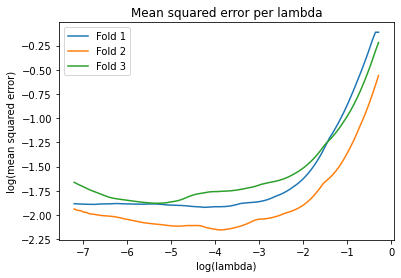


Most important coefficients:
                                             Coefficient
Degree Average                               -0.125127
Restaurant Price Index                       -0.117107
Road Deaths Rate (per 1000)                  -0.100915
Congestion Factor                            -0.084018
Highway Proportion                           -0.074903
Intersection Count                           -0.074736
Innovation Index                             -0.052279
Self-Loop Proportion                         -0.040282
Population Density (per sq. km)              -0.033193
BRT Annual Ridership per Capita              -0.028421
Life Expectancy (years)                      -0.025447
Cost of Living Index                         -0.025025
Subway Length Density (per km)               -0.022478
Population Change 2010 – 2020                 0.011416
Urbanization Rate Change 2015 – 2025 (pp)     0.015012
Subway Stations per Hundred Thousand          0.018917
Population                       

In [ ]:
temp = df.select_dtypes(include = ['float', 'int']).dropna(axis = 1)
x = temp.drop('CO2 Emissions per Capita (metric tonnes)', axis = 1)

y = temp['CO2 Emissions per Capita (metric tonnes)']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .25, shuffle = False)
x_train_std = (x_train - np.mean(x_train))/np.std(x_train)
x_test_std = (x_test - np.mean(x_test))/np.std(x_test)

y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

lasso_model = LassoCV(cv=3, random_state=0, n_alphas=100, tol = 0.001).fit(x_train_std, y_train);
plt.plot(np.log(lasso_model.alphas_), np.log(lasso_model.mse_path_))
print("Best lambda: ", lasso_model.alpha_)
plt.xlabel("log(lambda)")
plt.ylabel("log(mean squared error)")
plt.title("Mean squared error per lambda")
plt.legend(['Fold 1', 'Fold 2', 'Fold 3'])
plt.show()
coefficients = pd.DataFrame(data = lasso_model.coef_, index = x_train_std.columns.tolist(), columns=["Coefficient"])
coefficients = np.exp(coefficients) - 1
coefficients = coefficients[abs(coefficients['Coefficient']) >= 0.01]

print("\nMost important coefficients:\n ", coefficients.sort_values(by = 'Coefficient'))
print("\nNumber of selected features:", coefficients.shape[0])

y_pred_lasso = lasso_model.predict(x_test_std)
y_pred_lasso_train = lasso_model.predict(x_train_std)
y_pred_lasso_test = lasso_model.predict(x_test_std)

print("\nEvaluation of lasso regression, TRAINING RESULTS:")
evaluate(np.exp(y_train)-1, np.exp(y_pred_lasso_train)-1, x_train.shape[1])
print("\nEvaluation of lasso regression, TEST RESULTS:")
evaluate(np.exp(y_test)-1, np.exp(y_pred_lasso_test)-1, x_train.shape[1])

# extracting significant variables to perform linear regression
lasso_res = pd.DataFrame(data = lasso_model.coef_, index = x_train_std.columns.tolist(), columns=["coef"])
cols = lasso_res[lasso_res.coef != 0].index.tolist()
x = df[coefficients.index.tolist()]
y = df['CO2 Emissions per Capita (metric tonnes)']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .25, shuffle = False)
x_train_std = (x_train - np.mean(x_train))/np.std(x_train)
x_test_std = (x_test - np.mean(x_test))/np.std(x_test)

y_train = np.log1p(y_train)
y_test = np.log1p(y_test)
lr = LinearRegression()

lr.fit(x_train_std, y_train)
y_pred_train = lr.predict(x_train_std)
y_pred_test = lr.predict(x_test_std)

print("\nEvaluation of linear regression fitted to features selected by lasso regression, TRAINING RESULTS:")
evaluate(np.exp(y_train)-1, np.exp(y_pred_train)-1, x_train.shape[1])
print("\nEvaluation of linear regression fitted to features selected by lasso regression, TEST RESULTS:")
evaluate(np.exp(y_test)-1, np.exp(y_pred_test)-1, x_train.shape[1])

The test results of a linear regression with features revealedby the lasso regression are now quite different but worse in our opinion. Although we got exceptionally high value of $R^2$ we cant really be happy because the adjusted value is much lower. It is of course due to considering much bigger set of features, which now consists of 31 of them. This results in a clear overfitting and an overcomplexity of the model, which is shown by the gap between $R^2$ and the adjusted $R^2$. 

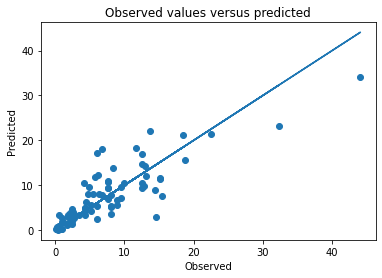

In [ ]:
plt.scatter(np.exp(y_test) - 1, np.exp(y_pred_test) - 1)
plt.plot(np.exp(y_test) - 1, np.exp(y_test) - 1)
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("Observed values versus predicted");

Mean of residuals: 0.2725962726955
Pvalue of Shapiro-Wilk normality test: 0.0003448310017120093


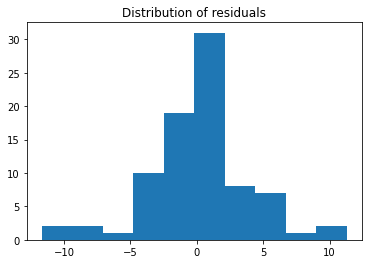

In [ ]:
errors = (np.exp(y_pred_test)-1 )- (np.exp(y_test)-1)
print("Mean of residuals:", np.mean(errors))
from scipy.stats import shapiro
print("Pvalue of Shapiro-Wilk normality test:", shapiro(errors)[1])
plt.hist(errors);
plt.title('Distribution of residuals');

Again it was impossible to perfectly meet the assumptions of OLS, although the distribution of errors for this model is the closest to normal among the considered models.

## Random Forrest Regressor

In this section we would like to use a Random Forest Regressor - another model that is suitable for regression problems available in the `sklearn` module.  
We made this choice since we wanted to check what would be the results of a model which is considered as one of the most accurate among all currently available. Additionally, there are no distributional assumptions that need to be met. Thus, we will refrain from applying log transformation in this example since random forests can handle skewed data well.  
  
In order to get as good results as possible, we first need to do some hyperparameter tuning. This is done with the help of `RandomizedSearchCV` method, which allows for defining a grid of hyperparameters ranges to randomly select from and performing a K-Fold cross validation with a selected combination of values.  
All of the considered values of different parameters are defined in a chunk below:

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 1000, stop = 5000, num = 5)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random_grid   

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [1000, 2000, 3000, 4000, 5000]}

**WARNING!** This chunk takes at least a couple of minutes to run. In our case running it on Google Colab took 15 minutes.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

cols_after = ['GDP per Capita (USD)', 'Congestion Factor', 'Population Density (per sq. km)',
        'Urbanization Rate 2015 (%)', 'Sprawl Factor', 'Public Transit Modeshare (%)']#'Walking Modeshare (%)', 
X = df[cols_after]
y = df['CO2 Emissions per Capita (metric tonnes)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, shuffle = False)
X_train = (X_train - np.mean(X_train))/np.std(X_train)
X_test = (X_test - np.mean(X_test))/np.std(X_test)

rf = RandomForestRegressor()
from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42,
                               n_jobs = -1)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 15.8min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [ ]:
print("Best set of hyperparameters:")
print(rf_random.best_estimator_)
best_random = rf_random.best_estimator_
print("\nEvaluation of Random Forest Regressor, TRAINING RESULTS:")
y_pred_train = best_random.predict(X_train)
evaluate(y_train, y_pred_train, X_train.shape[1])
print("\nEvaluation of Random Forest Regressor, TEST RESULTS:")
y_pred_test = best_random.predict(X_test)
evaluate(y_test, y_pred_test, X_train.shape[1])

Best set of hyperparameters:
RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=90, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=4000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Evaluation of Random Forest Regressor, TRAINING RESULTS:
R^2:      0.97
Adj. R^2: 0.969
MSE:      1.213
RMSE:     1.101
MAE:      0.598

Evaluation of Random Forest Regressor, TEST RESULTS:
R^2:      0.636
Adj. R^2: 0.607
MSE:      18.478
RMSE:     4.299
MAE:      2.662


The optimal set of parameters:  
* `n_estimators` (the number of trees in the forest) - 4000  
* `max_features` (the number of features to consider when looking for the best split) - 'sqrt' (square root of the number of all features)  
* `max_depth` (the maximum depth of the tree) - 90  
* `min_samples_split` (the minimum number of samples required to split an internal node) - 5  
* `min_samples_leaf` (the minimum number of samples required to be at a leaf node) - 2  
* `bootstrap` (whether bootstrap samples are used when building trees) - False (the whole dataset is used to build each tree)

As can be seen, we got unquestionably the best results on a training set among all models considered so far as well as the highest adjusted $R^2$ on the test set. But at the same time we also got the biggest difference between test and training results. Probably the only way to minimise this difference would to be to collect much more data.

## Neural Network

Additionally, we wanted to test a simple neural network and check its performance when predicting the CO2 emissions given our data. We will again use the features selected based on a correlation with the target and just like in case of Random Forest, we will not log transform the dependent variable.



In [ ]:
cols_after = ['CO2 Emissions per Capita (metric tonnes)', 'GDP per Capita (USD)', 'Congestion Factor', 'Population Density (per sq. km)',
        'Urbanization Rate 2015 (%)', 'Sprawl Factor', 'Public Transit Modeshare (%)']#'Walking Modeshare (%)', 

temp = df[cols_after]

X = temp.drop('CO2 Emissions per Capita (metric tonnes)', axis = 1)

y = temp['CO2 Emissions per Capita (metric tonnes)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, shuffle = False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, shuffle = False)

X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
X_train = (X_train - X_mean) / X_std
X_val = (X_val - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

The neural network consists of a sequence of two layers. We start by creating an object of the class `Sequential`. We set the loss function to Mean Squared Error.

Then we experimented with the values of hyperparameters like: 

  <li>Number of epochs</li>
  <li>Layers</li>
  <li>Number of neurons</li>

After thorough testing, we got the best results with the parameters set as below.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
n_epochs = 350
model = Sequential()
model.add(Dense(300, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

history = model.fit(X_train, y_train, epochs=n_epochs, validation_data=(X_val, y_val))

Epoch 1/350
8/8 [==============================] - 0s 19ms/step - loss: 88.3373 - mae: 7.0949 - val_loss: 74.1445 - val_mae: 6.1769
Epoch 2/350
8/8 [==============================] - 0s 4ms/step - loss: 70.8656 - mae: 6.1852 - val_loss: 57.9825 - val_mae: 5.2923
Epoch 3/350
8/8 [==============================] - 0s 4ms/step - loss: 51.9471 - mae: 5.2737 - val_loss: 40.2913 - val_mae: 4.3508
Epoch 4/350
8/8 [==============================] - 0s 4ms/step - loss: 36.1800 - mae: 4.3252 - val_loss: 24.7411 - val_mae: 3.3797
Epoch 5/350
8/8 [==============================] - 0s 4ms/step - loss: 22.9796 - mae: 3.4678 - val_loss: 15.9696 - val_mae: 2.8962
Epoch 6/350
8/8 [==============================] - 0s 6ms/step - loss: 20.3739 - mae: 3.3560 - val_loss: 14.8634 - val_mae: 2.8312
Epoch 7/350
8/8 [==============================] - 0s 5ms/step - loss: 16.1419 - mae: 3.0530 - val_loss: 14.1461 - val_mae: 2.7671
Epoch 8/350
8/8 [==============================] - 0s 5ms/step - loss: 19.4627 - m

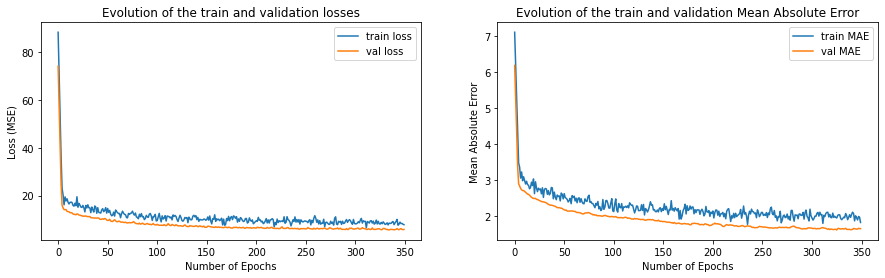

In [ ]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(range(n_epochs), history.history['loss'])
plt.plot(range(n_epochs), history.history['val_loss'])
plt.xlabel('Number of Epochs')
plt.ylabel('Loss (MSE)')
plt.legend(["train loss", "val loss"])
plt.title('Evolution of the train and validation losses')

plt.subplot(1, 2, 2)
plt.plot(range(n_epochs), history.history['mae'])
plt.plot(range(n_epochs), history.history['val_mae'])
plt.xlabel('Number of Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend(["train MAE", "val MAE"]);
plt.title('Evolution of the train and validation Mean Absolute Error');

In [ ]:
y_pred_train = model.predict(X_train).reshape(y_train.shape)
y_pred_test = model.predict(X_test).reshape(y_test.shape)

print("Neural Network, TRAINING RESULTS:")
evaluate(y_train, y_pred_train, X_test.shape[1])
print("\nNeural Network, TEST RESULTS:")
evaluate(y_test, y_pred_test, X_test.shape[1])

Neural Network, TRAINING RESULTS:
R^2:      0.858
Adj. R^2: 0.855
MSE:      5.66
RMSE:     2.379
MAE:      1.582

Neural Network, TEST RESULTS:
R^2:      0.672
Adj. R^2: 0.647
MSE:      16.608
RMSE:     4.075
MAE:      2.271


We tried to use three inner layers but the model was starting to overfit too quickly. We also experimented with different values of dropout rate. For lower ones the model was overfitting but for the higher values we could see an underfit due to too many connection between neurons being 'killed'.  
The plots, however, show an interesting effect, namely, the validation error is lower than the training error. Our explanation for this is that the **validation set could possibly contain more 'easy' cases** while the **training set could consist of rather 'hard' cases**. Furthermore, we can see that the **curve of the validation error is much more smooth**. This is due to the fact of using **dropout** which is usually activated during training and deactivated while evaluating on a validation set. This actually can also be the reason for having lower validation errors.  
When it comes to the test set results, we can see that the neural network outperformed random forest significantly and neural network was able to give the highest value of the adjusted $R^2$.  
However, in this case we can also see a relatively big difference between training and test results. And again, our solution to this problem would to be to gather more data.

# Prediction, part II

In the second part of prediction, we are asked to create a list with the cities that belong to North and South America only, and use it as a testing set, while the remaining cities must belong to the trainig set. This kind of split is done in the below chunk of code.

In [ ]:
americas = ['Brazil', 'Colombia', 'Argentina', 'Peru', 'Venezuela', 'Chile', 'Ecuador', 'Bolivia', 'Paraguay', 'Uruguay',
            'United States', 'Canada', 'Mexico', 'Guatemala', 'Cuba', 'Haiti', 'Dominican Republic', 'Honduras', 
            'El Salvador', 'Nicaragua', 'Costa Rica', 'Panama', 'Puerto Rico']

df['IsInAmerica'] = df['Country'].apply(lambda x: 1 if x in americas else 0)

print("Number of observation in a test set: ", sum(df['IsInAmerica']))

X_test = df[df['IsInAmerica'] == 1].drop(['CO2 Emissions per Capita (metric tonnes)'], axis = 1)
X_train = df[df['IsInAmerica'] == 0].drop(['CO2 Emissions per Capita (metric tonnes)'], axis = 1)
y_test = df[df['IsInAmerica'] == 1]['CO2 Emissions per Capita (metric tonnes)']
y_train = df[df['IsInAmerica'] == 0]['CO2 Emissions per Capita (metric tonnes)']

y_test.shape[0] + y_train.shape[0] == df.shape[0]
X_test.head()

Number of observation in a test set:  105


City cityID  ... Typology_MetroBike Giant IsInAmerica
0    Baltimore    285  ...                        0           1
5    Milwaukee    297  ...                        0           1
7   Montevideo    322  ...                        0           1
13      Austin    301  ...                        0           1
18     Chicago    269  ...                        0           1

[5 rows x 75 columns]

Next we fit an exactly the same linear regression model as in the first part of the prediction (it can be found in section *Linear Regression*).

In [ ]:
cols_after = ['GDP per Capita (USD)', 'Congestion Factor', 'Population Density (per sq. km)',
        'Urbanization Rate 2015 (%)', 'Sprawl Factor', 'Public Transit Modeshare (%)']#'Walking Modeshare (%)', 

X_train = X_train[cols_after]
X_test = X_test[cols_after]

X_train = (X_train - np.mean(X_train))/np.std(X_train)
X_test = (X_test - np.mean(X_test))/np.std(X_test)

lm = LinearRegression()
lm.fit(X_train, y_train)
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)
print("\nLinear regression after manual feature selection, TRAINING RESULTS:")
evaluate(y_train, y_pred_train, X_train.shape[1])
print("\nLinear regression after manual feature selection, TEST RESULTS:")
evaluate(y_test, y_pred_test, X_train.shape[1])


Linear regression after manual feature selection, TRAINING RESULTS:
R^2:      0.692
Adj. R^2: 0.684
MSE:      8.94
RMSE:     2.99
MAE:      2.095

Linear regression after manual feature selection, TEST RESULTS:
R^2:      0.354
Adj. R^2: 0.314
MSE:      39.315
RMSE:     6.27
MAE:      4.529


Part II of the prediction, shows that there is a striking difference when comparing the train and the test results. The $R^2$ for the training set is **0.69** while the $R^2$ for the test set is **only 0.35**. This is **twice as low** as the results in the first part. This is due to a **distribution mismatch** between the training and the test set that we introduced using cities that belong only to the Americas as the testing set. Given that, the test model is **unable to generalise well to data that it has not seen before** as the training set consists only of cities from Asia, Europe or Africa and the test set doesn’t have similar observations.  
This mismatch is shown in the below chunks as a difference between average values of features in a training and test set and is compared with the differences between test and training sets from the first part of prediction. There is no doubt that the dissimilarity is much serious for the splits obtained in the second part for every single feature.


In [ ]:
X = df[cols_after]
y = df['CO2 Emissions per Capita (metric tonnes)']

X_train_partI, X_test_partI, y_train_partI, y_test_partI = train_test_split(X, y, test_size = .25, shuffle = False)

np.abs(X_train_partI.describe().loc[['mean', '50%', 'std'],:] - X_test_partI.describe().loc[['mean', '50%', 'std'],:])

GDP per Capita (USD)  ...  Public Transit Modeshare (%)
mean           4036.386611  ...                      0.301114
50%            5413.500000  ...                      0.394577
std            2017.099196  ...                      0.052240

[3 rows x 6 columns]

In [ ]:
# Because we standardised the values for the prediction, now we do the split again to show the difference on a real values
X_test = df[df['IsInAmerica'] == 1].drop(['CO2 Emissions per Capita (metric tonnes)'], axis = 1)
X_train = df[df['IsInAmerica'] == 0].drop(['CO2 Emissions per Capita (metric tonnes)'], axis = 1)

cols_after = ['GDP per Capita (USD)', 'Congestion Factor', 'Population Density (per sq. km)',
        'Urbanization Rate 2015 (%)', 'Sprawl Factor', 'Public Transit Modeshare (%)']

X_train_partII = X_train[cols_after]
X_test_partII = X_test[cols_after]

np.abs(X_train_partII.describe().loc[['mean', '50%', 'std'],:] - X_test_partII.describe().loc[['mean', '50%', 'std'],:])

GDP per Capita (USD)  ...  Public Transit Modeshare (%)
mean          16913.578479  ...                      0.655779
50%           31513.500000  ...                      0.970954
std            2381.699509  ...                      0.193123

[3 rows x 6 columns]

Student contribution table:

In [ ]:
names = ['Valnose Adeline Edouazin (s134682)', 'Dimos Kadoglou (s205744)', 'Fotios Kotsalidis (s192909)', 'Katarzyna Otko (s202872)']
sections = ['Data Preparation', 'Exploratory analysis', 'Prediction']
contributions = [['20%', '20%', '20%', '40%'], ['20%', '20%', '20%', '40%'], ['20%', '15%', '15%', '50%']]
table = pd.DataFrame(columns = names, index = sections, data = contributions)
table

Valnose Adeline Edouazin (s134682)  ... Katarzyna Otko (s202872)
Data Preparation                                    20%  ...                      40%
Exploratory analysis                                20%  ...                      40%
Prediction                                          20%  ...                      50%

[3 rows x 4 columns]